# DEEPMIND ALPHAZERO CHESS

## TODO



## TODO LATER
#### - Get backward possibly loss to train the controller. Might need to save the tensor output like states, values, etc in MCTS
- Create Self play class
- Create Arena class

DEEP MIND OPEN ACCESS PAPER 

https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd

RAY ALPHA ZERO IMPLEMENTATION 

https://github.com/ray-project/ray/tree/master/rllib/contrib/alpha_zero

DUPLICATED MCTS IMPLEMENTATION

https://github.com/suragnair/alpha-zero-general/blob/master/MCTS.py

DISTRIBUTED IMPLEMENTATION

https://github.com/mokemokechicken/reversi-alpha-zero/blob/master/src/reversi_zero/lib/ggf.py

CHESS MOVES

https://www.ichess.net/blog/chess-pieces-moves/

BOARD REPRESENTATIONS

https://medium.com/datadriveninvestor/reconstructing-chess-positions-f195fd5944e

ALPHA ZERO EXPLANATION

https://nikcheerla.github.io/deeplearningschool/2018/01/01/AlphaZero-Explained/

TRANSFORMER NETWORK IMPLEMENTATION

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [1]:
import chess, gym, pickle, random, torch, math
import chess.svg as svg
import numpy as np
import pandas as pd
from copy import copy, deepcopy
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical
# plt.style.use('ggplot')
from scipy.ndimage.interpolation import shift
from copy import deepcopy
from colorama import init, Fore, Back, Style
from collections import Counter, deque
from tqdm import tqdm, tnrange, notebook
from random import shuffle
import tkinter as tk
from tkinter import simpledialog
from PyQt5.QtSvg import QSvgWidget
from PyQt5.QtWidgets import QApplication, QWidget

from utilities import *
# import constants 
from constants import *
from models.vae import CNN_VAE, train_vae, Conv
from models.mdn import MDN_RNN, loss_function, clip_grad_norm_
from models.controller import Controller

# init(convert = True)
# REFERENCES
# Tensorflow implementation for Chess
# https://github.com/saurabhk7/chess-alpha-zero

# Pytorch implementation for Connect4
# https://github.com/plkmo/AlphaZero_Connect4/tree/master/src

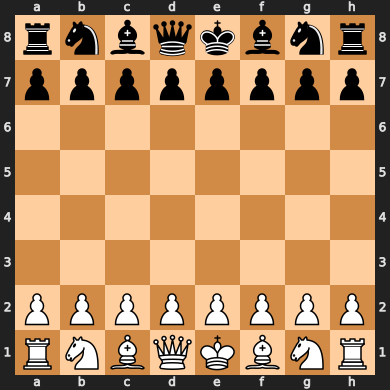

In [2]:
class Chess_Environment(gym.Env):
    """Chess Environment"""
    def __init__(self):
        self.board = chess.Board()
        self.white_pieces = ['P', 'N', 'B', 'R', 'Q', 'K']
        self.black_pieces = [piece.lower() for piece in self.white_pieces]
        self.x_coords, self.y_coords = np.meshgrid(list(range(0, 8)), list(range(0, 8)))
        self.x_coords = self.x_coords / 7
        self.y_coords = self.y_coords / 7
        self.state_size = self.observe()[0].shape
        self.init_action_decoder()
        self.whites_turn = True

    def reset(self):
        """Resets the environment"""
        self.board = chess.Board()
        
    def terminal_test(self):
        """Checks if the game is over"""
        return self.board.is_game_over(claim_draw = True)
    
    def result(self):
        """Gives the end game result"""

        result = self.board.result(claim_draw = True)
        if result == '1-0':
            return 1
        elif result == '0-1':
            return -1
        elif result == '1/2-1/2':
            return 0.5
        elif result == '*':
            return 0
        else:
            raise Exception('Invalid Result', result)
        
    def legal_actions(self):
        """Provides a list of legal actions in current state"""
        legal_actions = [str(legal_action) for legal_action in list(self.board.legal_moves)]
        return legal_actions
    
    def encode(self):
        """Encodes game state into a string"""
        board_ = self.board.piece_map()
            
        encoded = {
            'board' : board_,
            'turn' : self.board.turn,
            'legal_actions' : self.legal_actions()
        }
        
        return pickle.dumps(encoded)
    
    def decode(self, encoded):
        """Decodes string into game state and sets board and turn"""
        decoded = pickle.loads(encoded)
        self.board.set_piece_map(decoded['board'])
        if decoded['turn'] == False:
            self.board = self.board.mirror()
        self.board.turn = decoded['turn']

    def observe(self):
        """Create observation from the game state"""

        board_ = copy(self.board)
            
        board_ = np.ndarray.flatten(np.array(board_.__str__().split())).reshape(8, 8)
        
        black_pawns = np.isin(copy(board_), ['p']).astype(int)
        black_knights = np.isin(copy(board_), ['n']).astype(int)
        black_rooks = np.isin(copy(board_), ['r']).astype(int)
        black_bishops = np.isin(copy(board_), ['b']).astype(int)
        black_queen = np.isin(copy(board_), ['q']).astype(int)
        black_king = np.isin(copy(board_), ['k']).astype(int)
         
        white_pawns = np.isin(copy(board_), ['P']).astype(int)
        white_knights = np.isin(copy(board_), ['N']).astype(int)
        white_rooks = np.isin(copy(board_), ['R']).astype(int)
        white_bishops = np.isin(copy(board_), ['B']).astype(int)
        white_queen = np.isin(copy(board_), ['Q']).astype(int)
        white_king = np.isin(copy(board_), ['K']).astype(int)
        
        state = np.array([
            white_pawns,
            white_knights,
            white_rooks,
            white_bishops,
            white_queen,
            white_king,
            black_pawns,
            black_knights,
            black_rooks,
            black_bishops,
            black_queen,
            black_king
        ])
        
        return state, self.legal_actions()
    
    def step(self, action):
        """Perform a step in the environment"""
        try:
            self.board.push_uci(action)
        except ValueError:
            print(f"ACTION {action} LEGAL ACTIONS\n{self.legal_actions()}")
        self.board = self.board.mirror()
        if self.whites_turn:
            self.whites_turn = False
        else:
            self.whites_turn = True
        return self.observe()
    
    def move_board(self, move):
        """Moves the board positions as per the move"""

        char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

        int_to_char = {v: k for k, v in char_to_int.items()}

        encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(BOARD)]

        new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(BOARD)]
        moves = []
        for pos, new_pos in zip(np.ndarray.flatten(BOARD), new_board):
            try:
                if new_pos[1] > 8:
                    raise Exception()
                if move[2] is None:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
                else:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
                if '-' in move_:
                    raise Exception()
            
                if '0' in move_:
                    raise Exception()
                
            except Exception:
                move_ = 'XXXX'
            moves.append(move_)   
        return np.array(moves).reshape(8, 8)
    
    def init_action_decoder(self):
        """Initialize the decoder to decode the actions"""
        decoder = []
        for key in MOVES.keys():
            decoder_ = self.move_board(MOVES[key])
            decoder.append(decoder_)
#             print(f'Move {key}\n', new_board, '\n')
    
        self.decoder = np.array(decoder)
        self.action_size = self.decoder.shape
        
    def select_action(self, logits):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in self.legal_actions()}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))

        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        return action
    
    def render(self):
        """Render chess board"""
        chess.svg.board(board = self.board)  

env = Chess_Environment()
env.board

In [3]:
class Agent:
    
    def __init__(self, decoder, action_size, vae, mdn, controller, test_mode = False, batch_size = 64, lr = 1e-4, legal_multiplier = 2, save_freq = 30):
        self.batch_size = batch_size
        self.action_size = action_size
        self.legal_multiplier = legal_multiplier # To increase the value of legal actions and MCTS insight as the target policy
        self.decoder = decoder
        self.save_freq = save_freq
        self.vae = CNN_VAE(vae, None, 'Latest')
        self.mdn = MDN_RNN(mdn, None, 'Latest')
        params = {
            'hidden_size' : self.mdn.hidden_size,
            'z_size' : self.vae.z_size,
            'action_size' : action_size,
            'expansion_size': 1200
        }
        if test_mode:
            self.controller = Controller('Test', params, 'Latest')
        else:
            self.controller = Controller('Test', params, False)
        
        self.optimizer = Adam(self.controller.parameters(), lr = lr)
        
        self.char_to_int = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8} 
        self.char_to_int_promo = {'r': 1, 'b': 2, 'q': 3, 'k': 4, 'n': 5, '': 6} 
        
        moves_df = pd.DataFrame(list(zip(self.char_to_int.values(), self.char_to_int.keys())), columns = ['Ids', 'Labels'])
        promo_df = pd.DataFrame(list(zip(self.char_to_int_promo.values(), self.char_to_int_promo.keys())), columns = ['Ids', 'Labels'])
        self.move_actions_ohe = pd.get_dummies(moves_df['Ids'])
        self.promo_actions_ohe = pd.get_dummies(promo_df['Ids'])
        
        self.criterion_pi = nn.NLLLoss()
        self.criterion_v = nn.MSELoss()
        self.trained_times = 0
    
    def select_action(self, logits, legal_actions):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))
        
        legal_actions = list(legal_move_logits.keys())
        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        
        action_probabilities = {legal_actions[idx] : probabilities[idx] for idx in range(len(legal_actions))}
        return action, action_probabilities
    
    def one_hot_encode_action(self, action):
        """One hot encodes the action"""
        if len(action) == 4:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[''] - 1].values
            ]
        else:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[action[4]] - 1].values
            ]
        ohe_action = np.concatenate(encoded_action)
        return ohe_action
    
    def reset(self, batch_size):
        """Resets the MDNs hidden state"""
        self.hidden = self.mdn.init_hidden(batch_size)
        
    def act(self, state, legal_actions):
        """Gets an action from the agent"""
        state = torch.tensor(state).float().unsqueeze(0)
        mu, logvar = self.vae.encode(state)
        z = self.vae.reparameterize(mu, logvar).squeeze(-1)
        zh = torch.cat((z.to('cpu'), self.hidden[0].squeeze(0).to('cpu')), dim = 1)
        if zh.shape[0] > 1:
            raise Exception('Batch size > 1 not handled')
        logits, values = self.controller(zh)
        logits, value = logits.detach().squeeze(0).cpu().numpy(), values.detach().squeeze(0).cpu().numpy()[0]
        action, action_probabilities = self.select_action(logits, legal_actions)
        return action_probabilities, value, zh
    
    def train(self, experiences):
        """Trains the controller from the MCTS experiences"""
        batches = [experiences[i : i + self.batch_size] for i in range(0, len(experiences), self.batch_size)]
        for batch in deepcopy(batches):
            zh, target_action_probs, returns = zip(*batch)
            returns = torch.tensor(returns).float()
            zh = torch.tensor(np.concatenate(zh, axis = 0)).float()
            self.optimizer.zero_grad()
            logits, values = self.controller(zh)
            target_policies = self.target_policies(logits, target_action_probs)
            
            policy_losses = []
            value_losses = []
            
            for idx in range(logits.shape[0]):
                advantage = returns[idx] - values[idx]
                # converts logits to action probabilities
                policy_losses.append(-F.softmax(logits[idx], dim = 0) * advantage)
                value_losses.append(F.smooth_l1_loss(values[idx], returns[idx]))
            
            # sum up all the values of policy_losses and value_losses
            loss = torch.stack(policy_losses).mean() + torch.stack(value_losses).mean()
            print(loss)
            loss.backward()
            self.optimizer.step()
        if self.trained_times % self.save_freq == 0:
            print("SAVING")
            self.controller.name = f"{self.controller.name} {self.trained_times}"
            self.controller.save_model()
        self.trained_times += 1
                
    def target_policies(self, logits, legal_move_logits):
        """Takes the logits from the current policy and layers the insights from MCTS"""
        new_boards__ = [[x.lower() for x in list(np.ndarray.flatten(self.decoder))] for _ in range(logits.shape[0])]
        target_policies = []
        for idx in range(logits.shape[0]):
            new_boards___ = new_boards__[idx]
            logits__ = logits[idx].view(-1)
            legal_move_logits__ = {k.lower(): v * LEGAL_MULTIPIER for k, v in legal_move_logits_[idx].items()}
            for move, legal_move_logit in legal_move_logits__.items():
                index = new_boards___.index(move)
                logits__[index] += legal_move_logit
            target_policies.append(logits__)
        target_policies = torch.cat(target_policies, dim = 0).reshape(logits.shape[0], 76, 8, 8).float()
        return target_policies
    
agent = Agent(env.decoder, env.action_size, 'Test', 'Test', 'Test', test_mode = True)

agent.reset(1)
# print(len(TRAIN_EXAMPLES))
# agent.train(TRAIN_EXAMPLES)

checkpoints/Conv VAE/Test/

AI Running on cuda

CNN_VAE(
  (encoder): Sequential(
    (0): Conv(
      (conv): Conv2d(12, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (2): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (3): Conv(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (4): Conv(
      (conv): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
  )
  (enc_conv_mu): Conv(
    (conv): Conv1d(512, 600, kernel_size=(1,), stride=(1,), bias=False)
    (activation): ReLU()
  )
  (enc_conv_logvar): Conv(
    (conv): Conv1d(512, 600, kernel_size=(1,), stride=(1,), bias=False)
    (activation): ReLU()
  )
  (decoder): Sequential(
    (0): Con

#### Encode State

In [4]:
# state, legal_actions = env.observe()

# state_planes = [
#     'White Pawns',
#     'White Knights',
#     'White Rooks',
#     'White Bishops',
#     'White Queen',
#     'White King',
#     'Black Pawns',
#     'Black Knights',
#     'Black Rooks',
#     'Black Bishops',
#     'Black Queen',
#     'Black King'
# ]

# for inx, state_ in enumerate(state):
#     fig = plt.figure()
#     fig.suptitle(state_planes[inx], fontsize = 20)
#     xticks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
#     yticks = list(range(1, 9))
#     yticks.reverse()
#     plt.xticks(list(range(0, 8)), xticks)
#     plt.yticks(list(range(0, 8)), yticks)
#     plt.imshow(state_)


#### Encode Moves

In [5]:
# queen_directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
# queen_distance = list(range(1, 8))
# queen_moves = [f'{direction}{distance}' for direction in queen_directions for distance in queen_distance]

# knight_moves = ['2N1E', '1N2E', '1S2E', '2S1E', '2S1W', '1S2W', '1N2W', '2N1W']
# underpromotion_moves = ['DOUBLEM', 'NECUT', 'NWCUT']
# moves = queen_moves + knight_moves + underpromotion_moves

# print(f'{len(queen_moves)} QUEEN MOVES {queen_moves[: 15]}\n{len(knight_moves)} KNIGHT MOVES {knight_moves}\n{len(underpromotion_moves)} UNDERPROMOTION MOVES {underpromotion_moves}')
# print(f'\nTOTAL MOVES {len(moves)}')
# print(moves)

In [6]:
# def move_board(move):
#     """Moves the board positions as per the move"""
#     print(move)
#     board = np.array([
#         ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8'],
#         ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7'],
#         ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6'],
#         ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5'],
#         ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4'],
#         ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3'],
#         ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'],
#         ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1']
#     ])

#     char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

#     int_to_char = {v: k for k, v in char_to_int.items()}

#     encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(board)]

#     new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(board)]
 
#     moves = []
#     for pos, new_pos in zip(np.ndarray.flatten(board), new_board):
#         try:
# #             print(pos, new_pos)
#             if new_pos[1] > 8:
#                 raise Exception()
            
#             if move[2] is None:
#                 move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
#             else:
#                 move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
#             if '-' in move_:
#                 raise Exception()
            
#             if '0' in move_:
#                 raise Exception()
                
#         except Exception:
#             move_ = 'XXXX'
#         moves.append(move_)
#     return np.array(moves).reshape(8, 8)

# moves = {
#     # Queen Moves
#     'Q N1': (0, 1, None),
#     'Q N2': (0, 2, None),
#     'Q N3': (0, 3, None),
#     'Q N4': (0, 4, None),
#     'Q N5': (0, 5, None),
#     'Q N6': (0, 6, None),
#     'Q N7': (0, 7, None),
#     'Q NE1': (1, 1, None),
#     'Q NE2': (2, 2, None),
#     'Q NE3': (3, 3, None),
#     'Q NE4': (4, 4, None),
#     'Q NE5': (5, 5, None),
#     'Q NE6': (6, 6, None),
#     'Q NE7': (7, 7, None),
#     'Q E1': (1, 0, None),
#     'Q E2': (2, 0, None),
#     'Q E3': (3, 0, None),
#     'Q E4': (4, 0, None),
#     'Q E5': (5, 0, None),
#     'Q E6': (6, 0, None),
#     'Q E7': (7, 0, None),
#     'Q SE1': (1, -1, None),
#     'Q SE2': (2, -2, None),
#     'Q SE3': (3, -3, None),
#     'Q SE4': (4, -4, None),
#     'Q SE5': (5, -5, None),
#     'Q SE6': (6, -6, None),
#     'Q SE7': (7, -7, None),
#     'Q S1': (0, -1, None),
#     'Q S2': (0, -2, None),
#     'Q S3': (0, -3, None),
#     'Q S4': (0, -4, None),
#     'Q S5': (0, -5, None),
#     'Q S6': (0, -6, None),
#     'Q S7': (0, -7, None),
#     'Q SW1': (-1, -1, None),
#     'Q SW2': (-2, -2, None),
#     'Q SW3': (-3, -3, None),
#     'Q SW4': (-4, -4, None),
#     'Q SW5': (-5, -5, None),
#     'Q SW6': (-6, -6, None),
#     'Q SW7': (-7, -7, None),
#     'Q W1': (-1, 0, None),
#     'Q W2': (-2, 0, None),
#     'Q W3': (-3, 0, None),
#     'Q W4': (-4, 0, None),
#     'Q W5': (-5, 0, None),
#     'Q W6': (-6, 0, None),
#     'Q W7': (-7, 0, None),
#     'Q NW1': (-1, 1, None),
#     'Q NW2': (-2, 2, None),
#     'Q NW3': (-3, 3, None),
#     'Q NW4': (-4, 4, None),
#     'Q NW5': (-5, 5, None),
#     'Q NW6': (-6, 6, None),
#     'Q NW7': (-7, 7, None),
#     # Knight Moves
#     '2N1E' : (1, 2, None),
#     '1N2E' : (2, 1, None),
#     '1S2E' : (2, -1, None),
#     '2S1E' : (1, -2, None),
#     '2S1W' : (-1, -2, None),
#     '1S2W' : (-2, -1, None),
#     '1N2W' : (-2, 1, None),
#     '2N1W' : (-1, 2, None),
#     # Promtions
#     'PQ N1' : (0, 1, 'q'),
#     'PR N1' : (0, 1, 'r'),
#     'PB N1' : (0, 1, 'b'),
#     'PN N1' : (0, 1, 'n'),
#     'PQ NE1' : (1, 1, 'q'),
#     'PR NE1' : (1, 1, 'r'),
#     'PB NE1' : (1, 1, 'b'),
#     'PN NE1' : (1, 1, 'n'),
#     'PQ NW1' : (-1, 1, 'q'),
#     'PR NW1' : (-1, 1, 'r'),
#     'PB NW1' : (-1, 1, 'b'),
#     'PN NW1' : (-1, 1, 'n')
# }

# new_boards = []
# for key in moves.keys():
#     print(f'Move {key}')
#     new_board = move_board(moves[key])
#     new_boards.append(new_board)
#     print(new_board, '\n')
    
# new_boards = np.array(new_boards)
# new_boards.shape

#### Decode Logits

In [7]:
# # logits = env.action
# logits = np.random.rand(len(moves), 8, 8)

# print(env.action_size)
# new_boards_ = np.ndarray.flatten(new_boards)
# logits_ = np.ndarray.flatten(logits)

# move_logits = [(new_boards_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
# move_logits = dict(move_logits)

# legal_actions = ['g1h3','g1f3','b1c3','b1a3','h2h3','g2g3','f2f3','e2e3','d2d3','c2c3','b2b3','a2a3','h2h4','g2g4','f2f4','e2e4','d2d4','c2c4','b2b4','a2a4']

# legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
# legal_move_logits

#### Encode Logits FOR CONTROLLER TRAINING LOOP

In [8]:
# LEGAL_MULTIPIER = 20
# BATCH_SIZE = 64

# legal_move_logits_ = [legal_move_logits for _ in range(BATCH_SIZE)] 
# logits = np.random.rand(BATCH_SIZE, len(moves), 8, 8)
# logits_ = np.swapaxes(logits.reshape(-1, BATCH_SIZE), 0, 1)
# new_boards__ = [[x.lower() for x in list(new_boards_)] for _ in range(BATCH_SIZE)]
# target_policies = []
# for idx in range(BATCH_SIZE):
#     new_boards___ = new_boards__[idx]
#     logits__ = logits_[idx]
#     legal_move_logits__ = {k.lower(): v * LEGAL_MULTIPIER for k, v in legal_move_logits_[idx].items()}
#     for move, legal_move_logit in legal_move_logits__.items():
#         index = new_boards___.index(move)
#         logits__[index] += legal_move_logit
#     target_policies.append(logits__)
# target_policies = np.array(target_policies).reshape(BATCH_SIZE, len(moves), 8, 8)

#### Create Training Data for VAE and figure out action size

In [9]:
# def create_vae_training_data(games):
#     """Creates training date for CNN-VAE"""
#     actions = {}
#     states = {}
#     for game in range(1, games + 1):
#         env.reset()
#         state, legal_actions = env.observe()
#         encoded_state = env.encode()
#         states[encoded_state] = state
#         while not env.terminal_test():
#             action = random.choice(legal_actions)            
#             state, legal_actions = env.step(action)
#             encoded_state = env.encode()
#             states[encoded_state] = state
# #             actions[encoded_state] = agent.one_hot_encode_action(action)
#         print(f'Game {game} | Unique States {len(states.keys())} Unique Actions {len(actions)}', end = '\r')
    
#     validate_path('data/vae')
#     with open('data/vae/states.pkl', 'wb') as file:
#         pickle.dump(states, file)
#     with open('data/vae/actions.pkl', 'wb') as file:
#         pickle.dump(actions, file)
    
# create_vae_training_data(100)

#### Train VAE

In [10]:
# def train_vae_(name, starting_channels, filename, z_size, epochs, batch_size):
#     """Trains the CNN-VAE"""
#     params = {
#         'z_size' : z_size,
#         'batch_size' : batch_size,
#         'learning_rate' : 1e-4,
#         'kl_tolerance' : 0.5,
#         'batch_norm' : False,
#         'starting_channels' : starting_channels
#     }

#     vae = CNN_VAE(name, params, False)
#     with open(f'data/vae/{filename}',  'rb') as pickle_file:
#         data = list(pickle.load(pickle_file).values())
#         data = [np.array(data_) for data_ in data]
    
#     train_vae(vae, data, epochs, 100)

    
# train_vae_('Test States', env.state_size[0], 'states.pkl', 600, 100, 200)
# # train_vae_('Test Actions', env.action_size[0], 'actions.pkl', 600, 100, 200)

#### Create Training Data for MDN

In [11]:
# def create_mdn_training_data(name, games):
#     """Create training data for MDN-RNN"""
#     vae = CNN_VAE(name, None, 'Latest')
#     vae.eval()
#     data = pd.DataFrame(columns = ['Game ID', 'Sequence #', 'State ID'])
#     rollouts = []
#     transitions = 0
    
#     for game in range(1, games + 1):
#         states = []
#         actions = []
#         env.reset()
        
#         state, legal_actions = env.observe()
#         while not env.terminal_test():
#             action = random.choice(legal_actions)
#             states.append(state)
#             actions.append(agent.one_hot_encode_action(action))
#             state, legal_actions = env.step(action)
#             transitions += 1
            
#         mus, logvars = vae.encode(torch.tensor(states).float())
#         zs = vae.reparameterize(mus, logvars)
#         mus, logvars, zs = mus.squeeze(-1), logvars.squeeze(-1), zs.squeeze(-1)
#         actions = torch.tensor(actions).float().squeeze(-1)
#         zas = torch.cat([zs, actions], dim = 1)
#         rollouts.append((zs.detach().numpy(), actions.detach().numpy()))
        
#         print(f'Game {game} Transitions {transitions}', end = '\r')
    
#     validate_path('data/mdn')
#     with open('data/mdn/rollouts.pkl', 'wb') as file:
#         pickle.dump(rollouts, file)
    
    
# create_mdn_training_data('Test', 600)

In [12]:
# def training_mdn(vae_name, name):
#     torch.cuda.empty_cache() 
#     """Trains the MDN-RNN"""
#     epochs = 499
#     batch_size = 5
    
#     params = {
#         'hidden_size' : 100,
#         'gaussian_size' : 20,
#         'stacked_layers': 1,
#         'grad_clip' : 0.5,
#         'learning_rate' : 1e-4
#     }
    
#     with open(f'data/mdn/rollouts.pkl', 'rb') as pickle_file:
#         rollouts = pickle.load(pickle_file)
    
#     params['z_size'] = rollouts[0][0].shape[1]
#     params['action_size'] = rollouts[0][1].shape[1]
#     params['batch_size'] = batch_size
    
#     mdn = MDN_RNN(name, params, False)
    
#     mdn.train()
#     mdn = mdn.to(mdn.device)
#     optimizer = optim.Adam(mdn.parameters(), lr = mdn.learning_rate)
        
#     inputs = []
#     targets = []
#     seq_lengths = []
    
#     for rollout in rollouts:
#         zs, actions = rollout
#         zas = np.concatenate((zs, actions), axis = 1)
#         seq_lengths.append(zas.shape[0])
#         inputs.append(zas)
#         targets.append(zs)
        
#     idxs = range(len(rollouts))
    
#     # Sorts order from longest to shortest sequence
#     idxs = [x for _, x in sorted(zip(seq_lengths, idxs), reverse = True)]
#     seq_lengths = [seq_lengths[x] for x in idxs]
#     inputs = [np.array(inputs[x]) for x in idxs]
#     targets = [np.array(targets[x]) for x in idxs]
    
#     max_seq_len = max(seq_lengths)
#     rollout_size = len(seq_lengths)
    
#     padded_X = np.zeros((rollout_size, max_seq_len, inputs[0].shape[-1]))
#     padded_Y = np.zeros((rollout_size, max_seq_len, targets[0].shape[-1]))
# #     https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
    
#     for i, x_len in enumerate(seq_lengths):
#         padded_X[i, 0 : x_len] = inputs[i]
#         padded_Y[i, 0 : x_len] = targets[i]
        
#     inputs = torch.tensor(padded_X).float().squeeze(1).to(mdn.device)
#     targets = torch.tensor(padded_Y).float().squeeze(1).to(mdn.device)
    
#     if inputs.shape[0] % batch_size != 0:
#         inputs = inputs[inputs.shape[0] // batch_size, :, :]
        
#     inputs = inputs.reshape(-1, batch_size, max_seq_len, mdn.z_size + mdn.action_size)
#     targets = targets.reshape(-1, batch_size, max_seq_len, mdn.z_size)
#     seq_lengths = list(torch.tensor(seq_lengths).reshape(-1, batch_size).numpy())
    
#     for epoch in range(epochs + 1):
#         for batch in range(inputs.shape[0]):
#             inputs_ = inputs[batch]
#             targets_ = targets[batch]
#             seq_lengths_ = list(seq_lengths[batch])
            
#             targets_ = torch.nn.utils.rnn.pack_padded_sequence(targets_, seq_lengths_, batch_first = True)
#             targets_, _ = torch.nn.utils.rnn.pad_packed_sequence(targets_, batch_first = True)
            
#             # Set initial hidden and cell states
#             hidden = mdn.init_hidden(batch_size)

#             # Forward pass
#             hidden = (hidden[0].detach(), hidden[1].detach())
#             (pi, mu, sigma), hidden = mdn(inputs_, hidden, seq_lengths_)
#             loss = loss_function(targets_, pi, mu, sigma)

#             # Backward and optimize
#             mdn.zero_grad()
#             loss.backward()
#             clip_grad_norm_(mdn.parameters(), mdn.grad_clip)
#             optimizer.step()
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, loss.item()))
            
#     mdn.save_model()
# training_mdn('Test', 'Test')

# ALPHA GO TIPS 


## MCTS
Each simulation proceeds by
selecting in each state s a move a with low visit count, high move probability and high value
(averaged over the leaf states of simulations that selected a from s) according to the current
neural network fθ. The search returns a vector π representing a probability distribution over
moves, either proportionally or greedily with respect to the visit counts at the root state.
The parameters θ of the deep neural network in AlphaZero are trained by self-play reinforcement learning, starting from randomly initialised parameters θ. Games are played by selecting
moves for both players by MCTS, at ∼ πt
. At the end of the game, the terminal position sT is
scored according to the rules of the game to compute the game outcome z: −1 for a loss, 0 for
a draw, and +1 for a win. The neural network parameters θ are updated so as to minimise the
error between the predicted outcome vt and the game outcome z, and to maximise the similarity
of the policy vector pt
to the search probabilities πt
. Specifically, the parameters θ are adjusted
by gradient descent on a loss function l that sums over mean-squared error and cross-entropy
losses respectively

(p, v) = fθ(s)                    

l = (z − v) 2 − π > log p + c||θ||2


In [14]:
agent = Agent(env.decoder, env.action_size, 'Test', 'Test', 'Test', test_mode = False)

agent.reset(1)

checkpoints/Conv VAE/Test/

AI Running on cuda

CNN_VAE(
  (encoder): Sequential(
    (0): Conv(
      (conv): Conv2d(12, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (2): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (3): Conv(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (4): Conv(
      (conv): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
  )
  (enc_conv_mu): Conv(
    (conv): Conv1d(512, 600, kernel_size=(1,), stride=(1,), bias=False)
    (activation): ReLU()
  )
  (enc_conv_logvar): Conv(
    (conv): Conv1d(512, 600, kernel_size=(1,), stride=(1,), bias=False)
    (activation): ReLU()
  )
  (decoder): Sequential(
    (0): Con

In [15]:
class MCTS():
    """Monte Carlo Tree Search Algorithm geared for Neural Networks"""

    def __init__(self, env, agent, mcts_simulations = 100, max_depth = 100, delta = 0.5):
        self.env = env
        self.agent = agent
        self.cpuct = 0.2    # WARNING BULLSHIT NUMBER!
        self.delta = delta  # value to prevent crash if no edges are visited
        self.mcts_simulations = mcts_simulations
        self.max_depth = max_depth
        
        self.Qsa = {}       # stores Q values for s, a (as defined in the paper)
        self.Nsa = {}       # stores # times edge s, a was visited
        self.Ns = {}        # stores # times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores victory result (1, 0, -1) ended for board s
        self.Vs = {}        # stores legal actions for board s
        self.zh = {}        # stores preserved state that is fed into the controller

    def action_probabilities(self, encoded_state, temp = 1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for runs in range(self.mcts_simulations):
#             print(f"{Fore.BLUE}MCTS SIMULATION {runs + 1}{Style.RESET_ALL}")
            self.search(encoded_state, 0)
        
        s = encoded_state
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in legal_actions]
        # counts array represent the number of time each action edge from your current state was traversed

        if temp == 0: # temprature is 0 representing taking the best action possible (greedy)
            bestA = np.argmax(counts) # bestA: best action number : argmax Returns the indices of the maximum values
            probs = [0] * len(counts)
            probs[bestA] = 1
            action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
            return action_probs # returns the definite move(s) with same greedy reward, out of which one move HAS to be played
        
#         print(f"{Fore.BLUE}COUNTS {sum(counts)} {counts}{Style.RESET_ALL}")
        
        # Handles frequent draw situation when MCTS fails to explore when the game is over resulting 0 counts causing div 0 error
        if sum(counts) == 0:
            counts = [1 for _ in counts]
        counts = [x ** (1. / temp) + 0.5 for x in counts]
        probs = [x / float(sum(counts)) for x in counts]
        action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
        # If the game isn't over return the state zh or return None at the end
        if self.env.result() != 0:
            return action_probs, None
        return action_probs, self.zh[s]  
        #returns the probablity of different moves that CAN be played resulting in uniform distribution


    def search(self, encoded_state, depth):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propogated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propogated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = deepcopy(encoded_state)
        self.env.decode(encoded_state)
#         print(f"{Fore.GREEN}SEARCH DEPTH {depth}{Style.RESET_ALL}")
        
        # Check if its an terminal state, -1 Opponent Won, 0 Game not Over, 1 Player Won
        if s not in self.Es:
            self.Es[s] = self.env.result()
        if self.Es[s] != 0 or self.env.terminal_test():
#             print("SIMULATION OVER!", self.env.terminal_test(), -self.Es[s], self.env.board.result())
            return -self.Es[s]
        
        state, legal_actions = self.env.observe()
#         legal_actions = self.env.legal_actions()

        if s not in self.Ps: #if the current state 's' is not explored/expanded before n=0 by MCTS then create a new node and rollout
            self.Ps[s], v, self.zh[s] = self.agent.act(state, legal_actions)
#             print("self.Ps[s] at Depth", depth, "\n", self.Ps[s])
            valids = legal_actions

            self.Vs[s] = valids 
            self.Ns[s] = 0
#             print("VALUE", -v)
            return -v
        
        valids = self.Vs[s] #as already visited the valid moves array 'Vs' is already initialized
        cur_best = -float('inf')
        best_act = -1
        
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        # pick the action with the highest upper confidence bound
        
        agent_actions = list(self.Ps[s].keys())
        
        # Handles the occasional legal action that isn't an actual legal action
        # Pawn side cut even though there is no enemy piece in respective position
#         print("XXXXX PRE LEGAL ACTIONS\n", legal_actions)
        if not set(agent_actions) == set(legal_actions):
            legal_actions = agent_actions
#         print("XXXXX POST LEGAL ACTIONS\n", legal_actions)
        for a in legal_actions:
            if (s,a) in self.Qsa:
                u = self.Qsa[(s,a)] + self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (1 + self.Nsa[(s,a)])
#                 print("In Qsa")
            else:
                self.Ps[s][a] 
                u = self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s])     # Q = 0 ? : node exists but not explored as added and initilized during nnet phase
#                 print("Not In Qsa", self.Ps[s][a], self.Ns[s], math.sqrt(self.Ns[s]))
#             print("U", u)
            if math.isnan(u):
                u = 0
#                 print("Override U", u)
            if u > cur_best:
                cur_best = u
                best_act = a
#         print(f"{Fore.GREEN}BEST ACTION {best_act}{Style.RESET_ALL}")
        a = best_act

        _, _ = self.env.step(a)
        encoded_next_state = self.env.encode()

        v = self.search(encoded_next_state, depth + 1) # RECURSION until leaf node or terminal node is found
        
        self.env.decode(encoded_state)
        
        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)] * self.Qsa[(s,a)] + v) / (self.Nsa[(s,a)] + 1) #update the Q Value
            self.Nsa[(s,a)] += 1 # increment number of visits to this node in MCTS
        else:
            self.Qsa[(s,a)] = v # initialize the new node
            self.Nsa[(s,a)] = 1

        self.Ns[s] += 1
        return -v
    
    def reset(self):
        """Resets the tracked information"""
        self.Qsa = {}       
        self.Nsa = {}       
        self.Ns = {}        
        self.Ps = {}       
        self.Es = {}
        self.Vs = {}  
        self.zh = {}
        self.agent.reset(1)
        self.env.reset()

for _ in range(5):
    env.reset()
    mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
    mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
    game_move = 0
    while not env.terminal_test():
    #     print(f"{Fore.RED}GAME MOVE {game_move}{Style.RESET_ALL}")
        encoded_state = env.encode()
        if env.whites_turn: 
            action_probs, zh = mcts_white.action_probabilities(encoded_state)
        else:
            action_probs, zh = mcts_black.action_probabilities(encoded_state)
        action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
        print(f"{Fore.CYAN}ACTUAL MOVE\n {action_probs}{Style.RESET_ALL}")
        _, _ = env.step(action)
    
        game_move += 1    
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! GAME COMPLETED !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

ACTUAL MOVE
 {'g1h3': 0.05172413793103448, 'g1f3': 0.017241379310344827, 'b1c3': 0.05172413793103448, 'b1a3': 0.05172413793103448, 'h2h3': 0.017241379310344827, 'g2g3': 0.017241379310344827, 'f2f3': 0.5344827586206896, 'e2e3': 0.017241379310344827, 'd2d3': 0.017241379310344827, 'c2c3': 0.017241379310344827, 'b2b3': 0.017241379310344827, 'a2a3': 0.017241379310344827, 'h2h4': 0.05172413793103448, 'g2g4': 0.017241379310344827, 'f2f4': 0.017241379310344827, 'e2e4': 0.017241379310344827, 'd2d4': 0.017241379310344827, 'c2c4': 0.017241379310344827, 'b2b4': 0.017241379310344827, 'a2a4': 0.017241379310344827}
ACTUAL MOVE
 {'g1h3': 0.39655172413793105, 'g1f3': 0.08620689655172414, 'b1c3': 0.05172413793103448, 'b1a3': 0.08620689655172414, 'h2h3': 0.017241379310344827, 'g2g3': 0.017241379310344827, 'f2f3': 0.017241379310344827, 'e2e3': 0.017241379310344827, 'd2d3': 0.017241379310344827, 'c2c3': 0.017241379310344827, 'b2b3': 0.017241379310344827, 'a2a3': 0.017241379310344827, 'h2h4': 0.017241379310

C:\Users\SanujaPC\AppData\Local\conda\conda\envs\trader\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


ACTUAL MOVE
 {'h3g5': 0.5833333333333334, 'h3f4': 0.016666666666666666, 'h3g1': 0.016666666666666666, 'h1g1': 0.016666666666666666, 'f1g2': 0.05, 'c1a3': 0.016666666666666666, 'c1b2': 0.016666666666666666, 'b1c3': 0.016666666666666666, 'b1a3': 0.016666666666666666, 'b4a5': 0.016666666666666666, 'g4g5': 0.016666666666666666, 'b4b5': 0.016666666666666666, 'f2f3': 0.05, 'e2e3': 0.016666666666666666, 'd2d3': 0.016666666666666666, 'c2c3': 0.016666666666666666, 'a2a3': 0.016666666666666666, 'f2f4': 0.016666666666666666, 'e2e4': 0.016666666666666666, 'd2d4': 0.016666666666666666, 'c2c4': 0.016666666666666666, 'a2a4': 0.016666666666666666}
ACTUAL MOVE
 {'a4a7': 0.04477611940298507, 'a4a6': 0.014925373134328358, 'a4b5': 0.04477611940298507, 'a4a5': 0.014925373134328358, 'a4d4': 0.014925373134328358, 'a4c4': 0.014925373134328358, 'a4b4': 0.014925373134328358, 'a4b3': 0.014925373134328358, 'a3b5': 0.014925373134328358, 'a3c4': 0.014925373134328358, 'a3b1': 0.04477611940298507, 'g1h3': 0.014925373

ACTUAL MOVE
 {'h3f4': 0.4852941176470588, 'h3g1': 0.014705882352941176, 'a3b2': 0.014705882352941176, 'a3c1': 0.014705882352941176, 'h1g1': 0.014705882352941176, 'f1a6': 0.014705882352941176, 'f1b5': 0.014705882352941176, 'f1c4': 0.014705882352941176, 'f1d3': 0.014705882352941176, 'f1g2': 0.014705882352941176, 'f1e2': 0.014705882352941176, 'e1e2': 0.014705882352941176, 'd1h5': 0.014705882352941176, 'd1g4': 0.014705882352941176, 'd1f3': 0.014705882352941176, 'd1e2': 0.04411764705882353, 'd1c2': 0.014705882352941176, 'd1c1': 0.07352941176470588, 'd1b1': 0.014705882352941176, 'a1a2': 0.014705882352941176, 'a1c1': 0.014705882352941176, 'a1b1': 0.014705882352941176, 'g5f6': 0.014705882352941176, 'g5g6': 0.014705882352941176, 'b4b5': 0.014705882352941176, 'e3e4': 0.014705882352941176, 'f2f3': 0.014705882352941176, 'd2d3': 0.014705882352941176, 'f2f4': 0.014705882352941176, 'd2d4': 0.014705882352941176}
ACTUAL MOVE
 {'c7d8': 0.14666666666666667, 'c7c8': 0.013333333333333334, 'c7b8': 0.0133333

ACTUAL MOVE
 {'e2a6': 0.04, 'e2h5': 0.013333333333333334, 'e2b5': 0.04, 'e2g4': 0.013333333333333334, 'e2c4': 0.04, 'e2f3': 0.013333333333333334, 'e2d3': 0.013333333333333334, 'e2d1': 0.013333333333333334, 'b2e5': 0.22666666666666666, 'b2d4': 0.013333333333333334, 'b2c3': 0.013333333333333334, 'b2a3': 0.013333333333333334, 'b2a1': 0.013333333333333334, 'g1h3': 0.013333333333333334, 'g1f3': 0.04, 'f1h3': 0.013333333333333334, 'f1g2': 0.04, 'e1d1': 0.06666666666666667, 'c1c7': 0.04, 'c1c6': 0.013333333333333334, 'c1c5': 0.04, 'c1c4': 0.013333333333333334, 'c1c3': 0.013333333333333334, 'c1c2': 0.04, 'c1d1': 0.013333333333333334, 'c1b1': 0.04, 'c1a1': 0.013333333333333334, 'g5f6': 0.013333333333333334, 'g5g6': 0.013333333333333334, 'b4b5': 0.013333333333333334, 'e3e4': 0.013333333333333334, 'h2h3': 0.013333333333333334, 'f2f3': 0.013333333333333334, 'd2d3': 0.013333333333333334, 'h2h4': 0.013333333333333334, 'f2f4': 0.013333333333333334, 'd2d4': 0.013333333333333334}
ACTUAL MOVE
 {'e2f4': 

ACTUAL MOVE
 {'d4e6': 0.045454545454545456, 'd4c6': 0.045454545454545456, 'd4f5': 0.015151515151515152, 'd4b5': 0.015151515151515152, 'd4b3': 0.015151515151515152, 'd4e2': 0.19696969696969696, 'h1h3': 0.015151515151515152, 'h1h2': 0.015151515151515152, 'h1g1': 0.015151515151515152, 'f1g2': 0.25757575757575757, 'f1f2': 0.045454545454545456, 'f1e2': 0.015151515151515152, 'f1g1': 0.015151515151515152, 'f1e1': 0.015151515151515152, 'c1b2': 0.015151515151515152, 'b1c3': 0.015151515151515152, 'b1a3': 0.015151515151515152, 'f3g4': 0.015151515151515152, 'h4h5': 0.015151515151515152, 'e4e5': 0.015151515151515152, 'f3f4': 0.015151515151515152, 'd2d3': 0.10606060606060606, 'c2c3': 0.015151515151515152, 'a2a3': 0.015151515151515152, 'c2c4': 0.015151515151515152, 'a2a4': 0.015151515151515152}
ACTUAL MOVE
 {'b7c8': 0.037037037037037035, 'b7b8': 0.012345679012345678, 'b7a8': 0.012345679012345678, 'b7c7': 0.012345679012345678, 'b7a7': 0.012345679012345678, 'b7c6': 0.012345679012345678, 'b7b6': 0.01234

ACTUAL MOVE
 {'a6c8': 0.04054054054054054, 'a6b7': 0.013513513513513514, 'a6b5': 0.013513513513513514, 'a6c4': 0.013513513513513514, 'a6d3': 0.013513513513513514, 'a6e2': 0.013513513513513514, 'a6f1': 0.013513513513513514, 'f3g5': 0.04054054054054054, 'f3e5': 0.33783783783783783, 'f3d4': 0.12162162162162163, 'f3h2': 0.013513513513513514, 'f3g1': 0.013513513513513514, 'b2e5': 0.013513513513513514, 'b2d4': 0.013513513513513514, 'b2c3': 0.013513513513513514, 'b2a3': 0.013513513513513514, 'b2a1': 0.013513513513513514, 'h1h3': 0.013513513513513514, 'h1h2': 0.013513513513513514, 'h1g1': 0.013513513513513514, 'h1f1': 0.013513513513513514, 'e1e2': 0.013513513513513514, 'e1f1': 0.013513513513513514, 'e1d1': 0.04054054054054054, 'c1c6': 0.013513513513513514, 'c1c5': 0.013513513513513514, 'c1c4': 0.013513513513513514, 'c1c3': 0.013513513513513514, 'c1c2': 0.013513513513513514, 'c1d1': 0.013513513513513514, 'c1b1': 0.013513513513513514, 'c1a1': 0.013513513513513514, 'h4g5': 0.013513513513513514, '

ACTUAL MOVE
 {'c8d7': 0.19117647058823528, 'c8b7': 0.014705882352941176, 'c8a6': 0.014705882352941176, 'e5h8': 0.014705882352941176, 'e5g7': 0.014705882352941176, 'e5c7': 0.04411764705882353, 'e5f6': 0.014705882352941176, 'e5d6': 0.014705882352941176, 'e5f4': 0.014705882352941176, 'e5d4': 0.014705882352941176, 'e5g3': 0.25, 'e5c3': 0.014705882352941176, 'e5h2': 0.04411764705882353, 'e5b2': 0.014705882352941176, 'e5a1': 0.014705882352941176, 'f3g5': 0.014705882352941176, 'f3d4': 0.014705882352941176, 'f3h2': 0.014705882352941176, 'f3g1': 0.014705882352941176, 'f1h1': 0.014705882352941176, 'f1g1': 0.014705882352941176, 'e1e2': 0.014705882352941176, 'd1c1': 0.014705882352941176, 'd1b1': 0.014705882352941176, 'd1a1': 0.014705882352941176, 'b5c6': 0.10294117647058823, 'h4g5': 0.014705882352941176, 'b5b6': 0.014705882352941176, 'd2d3': 0.014705882352941176, 'd2d4': 0.014705882352941176}
ACTUAL MOVE
 {'c3f6': 0.2786885245901639, 'c3e5': 0.01639344262295082, 'c3d4': 0.01639344262295082, 'c3b4'

ACTUAL MOVE
 {'c3f6': 0.04477611940298507, 'c3e5': 0.014925373134328358, 'c3d4': 0.04477611940298507, 'c3b4': 0.014925373134328358, 'c3d2': 0.31343283582089554, 'c3b2': 0.014925373134328358, 'c3a1': 0.014925373134328358, 'a3b5': 0.014925373134328358, 'a3c4': 0.014925373134328358, 'a3b1': 0.04477611940298507, 'g2h2': 0.014925373134328358, 'g2f2': 0.04477611940298507, 'g2h1': 0.014925373134328358, 'g2g1': 0.04477611940298507, 'g2f1': 0.014925373134328358, 'e2f4': 0.014925373134328358, 'e2d4': 0.04477611940298507, 'e2g1': 0.014925373134328358, 'e2c1': 0.04477611940298507, 'e1h1': 0.014925373134328358, 'e1g1': 0.014925373134328358, 'e1f1': 0.014925373134328358, 'e1d1': 0.04477611940298507, 'e1c1': 0.014925373134328358, 'e1b1': 0.04477611940298507, 'e1a1': 0.014925373134328358, 'c2b3': 0.014925373134328358, 'a5a6': 0.014925373134328358, 'h4h5': 0.014925373134328358}
ACTUAL MOVE
 {'d7e8': 0.2833333333333333, 'd7c8': 0.016666666666666666, 'd7e6': 0.016666666666666666, 'd7c6': 0.01666666666666

ACTUAL MOVE
 {'d5e7': 0.0847457627118644, 'd5c7': 0.22033898305084745, 'd5f6': 0.01694915254237288, 'd5b6': 0.01694915254237288, 'd5f4': 0.01694915254237288, 'd5b4': 0.11864406779661017, 'd5e3': 0.0847457627118644, 'd5c3': 0.01694915254237288, 'e2d3': 0.01694915254237288, 'e2f2': 0.05084745762711865, 'e2d2': 0.0847457627118644, 'e2f1': 0.01694915254237288, 'd1e3': 0.05084745762711865, 'd1c3': 0.01694915254237288, 'd1f2': 0.05084745762711865, 'd1b2': 0.01694915254237288, 'c2b3': 0.01694915254237288, 'a5a6': 0.01694915254237288, 'h4h5': 0.01694915254237288, 'c2c3': 0.05084745762711865, 'c2c4': 0.01694915254237288}
ACTUAL MOVE
 {'e1f2': 0.7857142857142857, 'e1e2': 0.07142857142857142, 'e1d1': 0.07142857142857142, 'c1c2': 0.07142857142857142}
ACTUAL MOVE
 {'c7e8': 0.04918032786885246, 'c7a8': 0.04918032786885246, 'c7e6': 0.01639344262295082, 'c7a6': 0.01639344262295082, 'c7d5': 0.3442622950819672, 'c7b5': 0.01639344262295082, 'e2d3': 0.01639344262295082, 'e2f2': 0.01639344262295082, 'e2d2'

ACTUAL MOVE
 {'g8h7': 0.043478260869565216, 'g8f7': 0.014492753623188406, 'g8e6': 0.014492753623188406, 'g8d5': 0.014492753623188406, 'g8c4': 0.014492753623188406, 'g8b3': 0.014492753623188406, 'g8a2': 0.014492753623188406, 'f2g3': 0.014492753623188406, 'f2e3': 0.014492753623188406, 'f2g2': 0.014492753623188406, 'f2e2': 0.043478260869565216, 'f2g1': 0.014492753623188406, 'f2e1': 0.014492753623188406, 'c2c8': 0.014492753623188406, 'c2c7': 0.014492753623188406, 'c2c6': 0.043478260869565216, 'c2c5': 0.014492753623188406, 'c2c4': 0.014492753623188406, 'c2c3': 0.014492753623188406, 'c2d2': 0.043478260869565216, 'c2b2': 0.07246376811594203, 'c2a2': 0.014492753623188406, 'c2c1': 0.391304347826087, 'f1h1': 0.014492753623188406, 'f1g1': 0.014492753623188406, 'f1e1': 0.014492753623188406, 'f1d1': 0.014492753623188406, 'f1c1': 0.014492753623188406, 'f1b1': 0.014492753623188406, 'f1a1': 0.014492753623188406, 'f4f5': 0.014492753623188406}
ACTUAL MOVE
 {'d7f8': 0.05263157894736842, 'd7b8': 0.2280701

ACTUAL MOVE
 {'b8d7': 0.05172413793103448, 'b8c6': 0.05172413793103448, 'g2f4': 0.05172413793103448, 'g2e3': 0.05172413793103448, 'g2e1': 0.43103448275862066, 'f2e3': 0.05172413793103448, 'f2e2': 0.05172413793103448, 'f2f1': 0.05172413793103448, 'f2e1': 0.1206896551724138, 'a6a7': 0.017241379310344827, 'h4h5': 0.017241379310344827, 'b3b4': 0.05172413793103448}
ACTUAL MOVE
 {'h7g8': 0.04411764705882353, 'h7g6': 0.014705882352941176, 'd4d8': 0.16176470588235295, 'd4d7': 0.014705882352941176, 'd4d6': 0.014705882352941176, 'd4d5': 0.014705882352941176, 'd4e4': 0.10294117647058823, 'd4c4': 0.27941176470588236, 'd4b4': 0.014705882352941176, 'd4a4': 0.014705882352941176, 'd4d3': 0.04411764705882353, 'd4d2': 0.014705882352941176, 'd4d1': 0.014705882352941176, 'e2f3': 0.014705882352941176, 'e2e3': 0.014705882352941176, 'e2d3': 0.014705882352941176, 'e2f2': 0.014705882352941176, 'e2f1': 0.014705882352941176, 'e2e1': 0.014705882352941176, 'e2d1': 0.014705882352941176, 'g1g4': 0.014705882352941176

ACTUAL MOVE
 {'c2d4': 0.057692307692307696, 'c2b4': 0.057692307692307696, 'c2e3': 0.019230769230769232, 'c2a3': 0.019230769230769232, 'c2e1': 0.019230769230769232, 'c2a1': 0.4807692307692308, 'g1h2': 0.17307692307692307, 'g1g2': 0.057692307692307696, 'g1f2': 0.019230769230769232, 'g1h1': 0.019230769230769232, 'g1f1': 0.019230769230769232, 'a6a7': 0.019230769230769232, 'h4h5': 0.019230769230769232, 'b3b4': 0.019230769230769232}
ACTUAL MOVE
 {'b4b6': 0.04838709677419355, 'b4b5': 0.016129032258064516, 'b4e4': 0.016129032258064516, 'b4d4': 0.016129032258064516, 'b4c4': 0.016129032258064516, 'b4a4': 0.43548387096774194, 'b4b3': 0.04838709677419355, 'b4b2': 0.016129032258064516, 'b4b1': 0.04838709677419355, 'h3h4': 0.016129032258064516, 'h3g3': 0.016129032258064516, 'h3h2': 0.04838709677419355, 'h3g2': 0.016129032258064516, 'g1g4': 0.016129032258064516, 'g1g3': 0.016129032258064516, 'g1g2': 0.016129032258064516, 'g1h1': 0.016129032258064516, 'g1f1': 0.016129032258064516, 'g1e1': 0.0483870967

 {'d5d8': 0.05172413793103448, 'd5d7': 0.017241379310344827, 'd5d6': 0.017241379310344827, 'd5e5': 0.1206896551724138, 'd5c5': 0.1206896551724138, 'd5b5': 0.05172413793103448, 'd5a5': 0.017241379310344827, 'd5d4': 0.05172413793103448, 'd5d3': 0.017241379310344827, 'd5d2': 0.017241379310344827, 'd5d1': 0.25862068965517243, 'g2h3': 0.05172413793103448, 'g2f3': 0.017241379310344827, 'g2h2': 0.017241379310344827, 'g2f2': 0.05172413793103448, 'g2h1': 0.017241379310344827, 'g2g1': 0.017241379310344827, 'g2f1': 0.017241379310344827, 'f5g6': 0.05172413793103448, 'f5f6': 0.017241379310344827}
ACTUAL MOVE
 {'h2g3': 0.06818181818181818, 'h2g2': 0.06818181818181818, 'h2h1': 0.06818181818181818, 'h2g1': 0.7954545454545454}
ACTUAL MOVE
 {'d5d8': 0.05172413793103448, 'd5d7': 0.017241379310344827, 'd5d6': 0.017241379310344827, 'd5f5': 0.017241379310344827, 'd5e5': 0.1206896551724138, 'd5c5': 0.39655172413793105, 'd5b5': 0.017241379310344827, 'd5a5': 0.017241379310344827, 'd5d4': 0.05172413793103448, '

ACTUAL MOVE
 {'b8h8': 0.05, 'b8g8': 0.38333333333333336, 'b8f8': 0.016666666666666666, 'b8e8': 0.05, 'b8d8': 0.016666666666666666, 'b8c8': 0.05, 'b8a8': 0.05, 'b8b7': 0.05, 'b8b6': 0.05, 'b8b5': 0.016666666666666666, 'b8b4': 0.05, 'b8b3': 0.016666666666666666, 'b8b2': 0.016666666666666666, 'b8b1': 0.016666666666666666, 'g1h2': 0.08333333333333333, 'g1g2': 0.016666666666666666, 'g1f2': 0.016666666666666666, 'g1h1': 0.016666666666666666, 'g1f1': 0.016666666666666666, 'g5g6': 0.016666666666666666}
ACTUAL MOVE
 {'g2h2': 0.3333333333333333, 'g2f2': 0.3333333333333333, 'g2g1': 0.3333333333333333}
ACTUAL MOVE
 {'g1h2': 0.7321428571428571, 'g1g2': 0.05357142857142857, 'g1f2': 0.05357142857142857, 'g1h1': 0.05357142857142857, 'g1f1': 0.05357142857142857, 'g5g6': 0.05357142857142857}
ACTUAL MOVE
 {'a3b5': 0.05555555555555555, 'a3c4': 0.05555555555555555, 'a3c2': 0.05555555555555555, 'a3b1': 0.05555555555555555, 'g1h2': 0.05555555555555555, 'g1g2': 0.05555555555555555, 'g1f2': 0.05555555555555555

ACTUAL MOVE
 {'g1h2': 0.06976744186046512, 'g1g2': 0.06976744186046512, 'g1f2': 0.06976744186046512, 'g1h1': 0.06976744186046512, 'g1f1': 0.7209302325581395}
ACTUAL MOVE
 {'h3c8': 0.03225806451612903, 'h3d7': 0.03225806451612903, 'h3e6': 0.03225806451612903, 'h3f5': 0.03225806451612903, 'h3h4': 0.03225806451612903, 'h3g4': 0.03225806451612903, 'h3g3': 0.03225806451612903, 'h3f3': 0.03225806451612903, 'h3e3': 0.03225806451612903, 'h3d3': 0.03225806451612903, 'h3c3': 0.03225806451612903, 'h3b3': 0.03225806451612903, 'h3a3': 0.03225806451612903, 'h3h2': 0.03225806451612903, 'h3g2': 0.03225806451612903, 'h3h1': 0.03225806451612903, 'h3f1': 0.03225806451612903, 'g1h2': 0.03225806451612903, 'g1g2': 0.03225806451612903, 'g1f2': 0.03225806451612903, 'g1h1': 0.03225806451612903, 'g1f1': 0.03225806451612903, 'e1f3': 0.03225806451612903, 'e1d3': 0.03225806451612903, 'e1g2': 0.03225806451612903, 'e1c2': 0.03225806451612903, 'c7c8q': 0.03225806451612903, 'c7c8r': 0.03225806451612903, 'c7c8b': 0.032

ACTUAL MOVE
 {'g1h3': 0.05172413793103448, 'g1f3': 0.15517241379310345, 'b1c3': 0.017241379310344827, 'b1a3': 0.05172413793103448, 'h2h3': 0.017241379310344827, 'g2g3': 0.017241379310344827, 'f2f3': 0.017241379310344827, 'e2e3': 0.017241379310344827, 'd2d3': 0.017241379310344827, 'c2c3': 0.017241379310344827, 'b2b3': 0.3275862068965517, 'a2a3': 0.017241379310344827, 'h2h4': 0.15517241379310345, 'g2g4': 0.017241379310344827, 'f2f4': 0.017241379310344827, 'e2e4': 0.017241379310344827, 'd2d4': 0.017241379310344827, 'c2c4': 0.017241379310344827, 'b2b4': 0.017241379310344827, 'a2a4': 0.017241379310344827}
ACTUAL MOVE
 {'g1h3': 0.25862068965517243, 'g1f3': 0.05172413793103448, 'b1c3': 0.05172413793103448, 'b1a3': 0.29310344827586204, 'h2h3': 0.017241379310344827, 'g2g3': 0.017241379310344827, 'f2f3': 0.017241379310344827, 'e2e3': 0.017241379310344827, 'd2d3': 0.017241379310344827, 'c2c3': 0.017241379310344827, 'b2b3': 0.017241379310344827, 'a2a3': 0.017241379310344827, 'h2h4': 0.086206896551

ACTUAL MOVE
 {'d3d6': 0.390625, 'd3d5': 0.015625, 'd3d4': 0.046875, 'd3h3': 0.015625, 'd3g3': 0.015625, 'd3f3': 0.015625, 'd3e3': 0.015625, 'd3c3': 0.078125, 'd3b3': 0.015625, 'g1h3': 0.015625, 'g1f3': 0.046875, 'd1a4': 0.015625, 'd1b3': 0.015625, 'd1c2': 0.015625, 'b1c3': 0.046875, 'a1a2': 0.015625, 'c4c5': 0.015625, 'a3a4': 0.015625, 'g2g3': 0.015625, 'f2f3': 0.015625, 'e2e3': 0.046875, 'b2b3': 0.015625, 'g2g4': 0.015625, 'f2f4': 0.015625, 'e2e4': 0.046875, 'b2b4': 0.015625}
ACTUAL MOVE
 {'h3g5': 0.04477611940298507, 'h3f4': 0.04477611940298507, 'h3g1': 0.014925373134328358, 'e3h6': 0.014925373134328358, 'e3g5': 0.014925373134328358, 'e3c5': 0.04477611940298507, 'e3f4': 0.2835820895522388, 'e3d4': 0.014925373134328358, 'e3d2': 0.014925373134328358, 'e3c1': 0.014925373134328358, 'h1h2': 0.014925373134328358, 'h1g1': 0.014925373134328358, 'e1d2': 0.014925373134328358, 'd1d2': 0.014925373134328358, 'd1c1': 0.16417910447761194, 'd1b1': 0.04477611940298507, 'a1c1': 0.014925373134328358, '

ACTUAL MOVE
 {'b5c7': 0.21428571428571427, 'b5a7': 0.07142857142857142, 'b5d6': 0.014285714285714285, 'b5d4': 0.014285714285714285, 'c3h3': 0.04285714285714286, 'c3g3': 0.014285714285714285, 'c3f3': 0.04285714285714286, 'c3e3': 0.014285714285714285, 'c3d3': 0.014285714285714285, 'c3b3': 0.04285714285714286, 'c3c2': 0.04285714285714286, 'g1h3': 0.014285714285714285, 'g1f3': 0.014285714285714285, 'd1a4': 0.014285714285714285, 'd1b3': 0.12857142857142856, 'd1c2': 0.014285714285714285, 'a1a2': 0.014285714285714285, 'a1b1': 0.014285714285714285, 'c4c5': 0.014285714285714285, 'a3a4': 0.014285714285714285, 'g2g3': 0.014285714285714285, 'f2f3': 0.04285714285714286, 'e2e3': 0.07142857142857142, 'd2d3': 0.014285714285714285, 'b2b3': 0.014285714285714285, 'g2g4': 0.014285714285714285, 'f2f4': 0.014285714285714285, 'e2e4': 0.014285714285714285, 'd2d4': 0.014285714285714285, 'b2b4': 0.014285714285714285}
ACTUAL MOVE
 {'h3g5': 0.05172413793103448, 'h3f4': 0.017241379310344827, 'h3g1': 0.017241379310

ACTUAL MOVE
 {'g5h7': 0.3230769230769231, 'g5f7': 0.015384615384615385, 'g5e6': 0.2, 'g5e4': 0.015384615384615385, 'g5h3': 0.046153846153846156, 'h1h3': 0.015384615384615385, 'h1h2': 0.015384615384615385, 'h1g1': 0.015384615384615385, 'f1h3': 0.015384615384615385, 'f1g2': 0.015384615384615385, 'c1d1': 0.015384615384615385, 'b1h7': 0.015384615384615385, 'b1g6': 0.015384615384615385, 'b1f5': 0.015384615384615385, 'b1e4': 0.015384615384615385, 'b1d3': 0.015384615384615385, 'b1c2': 0.046153846153846156, 'b1a1': 0.015384615384615385, 'b2c3': 0.046153846153846156, 'g3g4': 0.015384615384615385, 'f3f4': 0.015384615384615385, 'e2e3': 0.015384615384615385, 'b2b3': 0.015384615384615385, 'a2a3': 0.015384615384615385, 'e2e4': 0.015384615384615385, 'b2b4': 0.015384615384615385, 'a2a4': 0.015384615384615385}
ACTUAL MOVE
 {'a8c7': 0.2463768115942029, 'a8b6': 0.014492753623188406, 'c3c5': 0.014492753623188406, 'c3c4': 0.014492753623188406, 'c3h3': 0.10144927536231885, 'c3g3': 0.014492753623188406, 'c3f

ACTUAL MOVE
 {'h7f8': 0.04918032786885246, 'h7f6': 0.01639344262295082, 'h7g5': 0.04918032786885246, 'g2h3': 0.01639344262295082, 'g2f1': 0.04918032786885246, 'h1h3': 0.01639344262295082, 'h1h2': 0.01639344262295082, 'h1g1': 0.04918032786885246, 'h1f1': 0.01639344262295082, 'h1e1': 0.01639344262295082, 'h1d1': 0.01639344262295082, 'c1c2': 0.04918032786885246, 'c1b1': 0.4098360655737705, 'a1b1': 0.04918032786885246, 'b2c3': 0.01639344262295082, 'g3g4': 0.01639344262295082, 'f3f4': 0.01639344262295082, 'e2e3': 0.01639344262295082, 'b2b3': 0.04918032786885246, 'a2a3': 0.01639344262295082, 'e2e4': 0.01639344262295082, 'b2b4': 0.01639344262295082, 'a2a4': 0.01639344262295082}
ACTUAL MOVE
 {'d3d8': 0.10144927536231885, 'd3d7': 0.043478260869565216, 'd3d6': 0.043478260869565216, 'd3d5': 0.014492753623188406, 'd3d4': 0.014492753623188406, 'd3h3': 0.014492753623188406, 'd3g3': 0.2753623188405797, 'd3f3': 0.014492753623188406, 'd3e3': 0.014492753623188406, 'd3c3': 0.13043478260869565, 'd3b3': 0.

ACTUAL MOVE
 {'h7f8': 0.047619047619047616, 'h7f6': 0.015873015873015872, 'h7g5': 0.047619047619047616, 'd3d4': 0.015873015873015872, 'd3c4': 0.015873015873015872, 'd3e3': 0.047619047619047616, 'd3c3': 0.3333333333333333, 'd3d2': 0.015873015873015872, 'd3c2': 0.015873015873015872, 'g2h3': 0.015873015873015872, 'g2h1': 0.015873015873015872, 'f1f2': 0.047619047619047616, 'f1h1': 0.015873015873015872, 'f1g1': 0.047619047619047616, 'f1e1': 0.1111111111111111, 'f1d1': 0.015873015873015872, 'f1c1': 0.047619047619047616, 'f1b1': 0.015873015873015872, 'f1a1': 0.015873015873015872, 'g3g4': 0.015873015873015872, 'f3f4': 0.015873015873015872, 'e2e3': 0.015873015873015872, 'a2a3': 0.015873015873015872, 'e2e4': 0.015873015873015872, 'a2a4': 0.015873015873015872}
ACTUAL MOVE
 {'h8g8': 0.046875, 'h8f8': 0.015625, 'h8h7': 0.015625, 'h8h6': 0.015625, 'h8h5': 0.015625, 'g1h3': 0.015625, 'g1f3': 0.171875, 'e1f2': 0.390625, 'd1a4': 0.015625, 'd1b3': 0.015625, 'd1c2': 0.015625, 'a1a2': 0.015625, 'a1b1': 0.

ACTUAL MOVE
 {'h8g8': 0.037037037037037035, 'h8f8': 0.16049382716049382, 'h8e8': 0.037037037037037035, 'h8d8': 0.012345679012345678, 'h8c8': 0.012345679012345678, 'h8b8': 0.012345679012345678, 'h8a8': 0.012345679012345678, 'h8h7': 0.037037037037037035, 'h8h6': 0.012345679012345678, 'g3h3': 0.012345679012345678, 'g3h2': 0.08641975308641975, 'g3f2': 0.037037037037037035, 'g1h3': 0.037037037037037035, 'g1f3': 0.037037037037037035, 'd1c2': 0.012345679012345678, 'd1e1': 0.012345679012345678, 'c1b2': 0.012345679012345678, 'b1b2': 0.1111111111111111, 'b1a1': 0.037037037037037035, 'b3b4': 0.012345679012345678, 'a3a4': 0.012345679012345678, 'e2e3': 0.18518518518518517, 'd2d3': 0.012345679012345678, 'e2e4': 0.012345679012345678, 'd2d4': 0.037037037037037035}
ACTUAL MOVE
 {'h3f5': 0.046875, 'h3g4': 0.015625, 'h3g2': 0.015625, 'h3f1': 0.484375, 'c2d3': 0.015625, 'c2c3': 0.015625, 'c2b3': 0.015625, 'c2d2': 0.015625, 'b2g7': 0.015625, 'b2f6': 0.046875, 'b2b6': 0.015625, 'b2e5': 0.015625, 'b2b5': 0.0

ACTUAL MOVE
 {'h3c8': 0.04225352112676056, 'h3d7': 0.014084507042253521, 'h3e6': 0.014084507042253521, 'h3f5': 0.014084507042253521, 'h3g4': 0.014084507042253521, 'h3g2': 0.014084507042253521, 'h3f1': 0.014084507042253521, 'd3d4': 0.014084507042253521, 'd3e3': 0.4647887323943662, 'd3c3': 0.04225352112676056, 'd3d2': 0.04225352112676056, 'd3c2': 0.014084507042253521, 'b2h8': 0.014084507042253521, 'b2g7': 0.014084507042253521, 'b2f6': 0.014084507042253521, 'b2e5': 0.014084507042253521, 'b2b5': 0.014084507042253521, 'b2d4': 0.014084507042253521, 'b2b4': 0.014084507042253521, 'b2c3': 0.014084507042253521, 'b2b3': 0.014084507042253521, 'b2a3': 0.014084507042253521, 'b2d2': 0.014084507042253521, 'b2c2': 0.014084507042253521, 'b2c1': 0.014084507042253521, 'b2b1': 0.014084507042253521, 'b2a1': 0.014084507042253521, 'f4f5': 0.014084507042253521, 'g3g4': 0.014084507042253521, 'e2e3': 0.014084507042253521, 'a2a3': 0.014084507042253521, 'e2e4': 0.014084507042253521, 'a2a4': 0.014084507042253521}
A

ACTUAL MOVE
 {'f2g2': 0.07142857142857142, 'f2f1': 0.023809523809523808, 'f2e1': 0.023809523809523808, 'h3g2': 0.8809523809523809}
ACTUAL MOVE
 {'d6d8': 0.21794871794871795, 'd6b8': 0.01282051282051282, 'd6e7': 0.038461538461538464, 'd6d7': 0.01282051282051282, 'd6c7': 0.01282051282051282, 'd6g6': 0.038461538461538464, 'd6f6': 0.01282051282051282, 'd6e6': 0.01282051282051282, 'd6c6': 0.0641025641025641, 'd6b6': 0.01282051282051282, 'd6a6': 0.01282051282051282, 'd6e5': 0.01282051282051282, 'd6d5': 0.0641025641025641, 'd6c5': 0.01282051282051282, 'd6f4': 0.01282051282051282, 'h3g5': 0.01282051282051282, 'h3f4': 0.01282051282051282, 'h3f2': 0.01282051282051282, 'h3g1': 0.01282051282051282, 'h2h1': 0.01282051282051282, 'h2g1': 0.01282051282051282, 'g2f3': 0.01282051282051282, 'g2h1': 0.01282051282051282, 'g2f1': 0.01282051282051282, 'c1h6': 0.01282051282051282, 'c1g5': 0.01282051282051282, 'c1f4': 0.01282051282051282, 'c1e3': 0.01282051282051282, 'c1d2': 0.038461538461538464, 'c1b2': 0.012

ACTUAL MOVE
 {'b8h8': 0.04054054054054054, 'b8g8': 0.013513513513513514, 'b8f8': 0.013513513513513514, 'b8e8': 0.013513513513513514, 'b8d8': 0.013513513513513514, 'b8c8': 0.013513513513513514, 'b8a8': 0.04054054054054054, 'b8c7': 0.013513513513513514, 'b8b7': 0.013513513513513514, 'b8a7': 0.36486486486486486, 'b8d6': 0.013513513513513514, 'b8b6': 0.013513513513513514, 'b8e5': 0.04054054054054054, 'b8b5': 0.013513513513513514, 'h3g5': 0.013513513513513514, 'h3f4': 0.04054054054054054, 'h3f2': 0.013513513513513514, 'h3g1': 0.013513513513513514, 'g2e4': 0.013513513513513514, 'g2f3': 0.013513513513513514, 'g2f1': 0.04054054054054054, 'h1h2': 0.013513513513513514, 'h1g1': 0.013513513513513514, 'c1f4': 0.013513513513513514, 'c1e3': 0.013513513513513514, 'c1d2': 0.04054054054054054, 'c1b2': 0.013513513513513514, 'a1a2': 0.013513513513513514, 'a1b1': 0.013513513513513514, 'g3f4': 0.013513513513513514, 'd5d6': 0.013513513513513514, 'b4b5': 0.013513513513513514, 'g3g4': 0.013513513513513514, 'a3

ACTUAL MOVE
 {'h3g5': 0.0410958904109589, 'h3f4': 0.0684931506849315, 'h3f2': 0.0410958904109589, 'h3g1': 0.0410958904109589, 'g2e4': 0.0958904109589041, 'g2f3': 0.0410958904109589, 'g2f1': 0.0958904109589041, 'h1h2': 0.0136986301369863, 'h1g1': 0.2054794520547945, 'c1h6': 0.0136986301369863, 'c1g5': 0.0410958904109589, 'c1f4': 0.0136986301369863, 'c1e3': 0.0410958904109589, 'c1a3': 0.0136986301369863, 'c1d2': 0.0410958904109589, 'c1b2': 0.0136986301369863, 'a1a3': 0.0136986301369863, 'a1a2': 0.0410958904109589, 'a1b1': 0.0136986301369863, 'd5d6': 0.0136986301369863, 'b4b5': 0.0136986301369863, 'a4a5': 0.0410958904109589, 'g3g4': 0.0136986301369863, 'e2e3': 0.0136986301369863, 'e2e4': 0.0136986301369863}
ACTUAL MOVE
 {'f3a8': 0.04838709677419355, 'f3b7': 0.04838709677419355, 'f3c6': 0.016129032258064516, 'f3h5': 0.016129032258064516, 'f3d5': 0.04838709677419355, 'f3g4': 0.04838709677419355, 'f3e4': 0.016129032258064516, 'f3e3': 0.04838709677419355, 'f3d3': 0.04838709677419355, 'f3c3': 

ACTUAL MOVE
 {'e6g8': 0.039473684210526314, 'e6c8': 0.06578947368421052, 'e6f7': 0.039473684210526314, 'e6e7': 0.013157894736842105, 'e6d7': 0.013157894736842105, 'e6g6': 0.013157894736842105, 'e6f6': 0.013157894736842105, 'e6d6': 0.013157894736842105, 'e6c6': 0.039473684210526314, 'e6b6': 0.039473684210526314, 'e6a6': 0.013157894736842105, 'e6f5': 0.17105263157894737, 'e6e5': 0.09210526315789473, 'e6d5': 0.013157894736842105, 'e6g4': 0.013157894736842105, 'e6e4': 0.039473684210526314, 'e6c4': 0.013157894736842105, 'e6h3': 0.039473684210526314, 'e6e3': 0.013157894736842105, 'e6b3': 0.013157894736842105, 'e6a2': 0.013157894736842105, 'e2f3': 0.013157894736842105, 'e2d3': 0.013157894736842105, 'e2f2': 0.039473684210526314, 'e2d2': 0.013157894736842105, 'e2f1': 0.013157894736842105, 'e2e1': 0.039473684210526314, 'e2d1': 0.013157894736842105, 'h1a8': 0.013157894736842105, 'h1b7': 0.013157894736842105, 'h1c6': 0.013157894736842105, 'h1d5': 0.013157894736842105, 'h1e4': 0.013157894736842105,

ACTUAL MOVE
 {'c8h8': 0.04, 'c8g8': 0.013333333333333334, 'c8f8': 0.013333333333333334, 'c8e8': 0.013333333333333334, 'c8d8': 0.013333333333333334, 'c8b8': 0.04, 'c8d7': 0.013333333333333334, 'c8c7': 0.2, 'c8b7': 0.04, 'c8e6': 0.013333333333333334, 'c8c6': 0.013333333333333334, 'c8a6': 0.013333333333333334, 'c8f5': 0.04, 'c8c5': 0.013333333333333334, 'c8g4': 0.013333333333333334, 'c8c4': 0.013333333333333334, 'c8h3': 0.04, 'c8c3': 0.013333333333333334, 'c8c2': 0.013333333333333334, 'c8c1': 0.013333333333333334, 'e2d3': 0.013333333333333334, 'e2f2': 0.013333333333333334, 'e2d2': 0.17333333333333334, 'e2e1': 0.04, 'e2d1': 0.013333333333333334, 'h1a8': 0.013333333333333334, 'h1b7': 0.013333333333333334, 'h1c6': 0.04, 'h1d5': 0.013333333333333334, 'h1e4': 0.013333333333333334, 'h1f3': 0.013333333333333334, 'h1g2': 0.013333333333333334, 'f4f5': 0.013333333333333334, 'g3g4': 0.013333333333333334, 'a3a4': 0.013333333333333334}
ACTUAL MOVE
 {'d7f8': 0.12857142857142856, 'd7b8': 0.0428571428571

ACTUAL MOVE
 {'f8g8': 0.19696969696969696, 'f8e8': 0.015151515151515152, 'f8d8': 0.015151515151515152, 'f8c8': 0.015151515151515152, 'f8b8': 0.015151515151515152, 'f8a8': 0.015151515151515152, 'f8g7': 0.015151515151515152, 'f8f7': 0.13636363636363635, 'f8e7': 0.015151515151515152, 'f8h6': 0.015151515151515152, 'f8f6': 0.045454545454545456, 'g2a8': 0.045454545454545456, 'g2b7': 0.015151515151515152, 'g2c6': 0.16666666666666666, 'g2d5': 0.015151515151515152, 'g2e4': 0.015151515151515152, 'g2h3': 0.045454545454545456, 'g2f3': 0.015151515151515152, 'g2h1': 0.015151515151515152, 'g2f1': 0.015151515151515152, 'c1d2': 0.045454545454545456, 'c1c2': 0.015151515151515152, 'c1b2': 0.015151515151515152, 'c1d1': 0.015151515151515152, 'c1b1': 0.015151515151515152, 'f4f5': 0.015151515151515152, 'g3g4': 0.015151515151515152, 'a3a4': 0.015151515151515152}
ACTUAL MOVE
 {'h2h3': 0.07142857142857142, 'h2h1': 0.8809523809523809, 'f3g2': 0.023809523809523808, 'g1g2': 0.023809523809523808}
ACTUAL MOVE
 {'f7g

 {'a8b7': 0.05357142857142857, 'a8c6': 0.05357142857142857, 'a8d5': 0.05357142857142857, 'a8e4': 0.05357142857142857, 'a8f3': 0.05357142857142857, 'a8g2': 0.05357142857142857, 'a8h1': 0.05357142857142857, 'd2e3': 0.05357142857142857, 'd2d3': 0.30357142857142855, 'd2c3': 0.05357142857142857, 'd2e1': 0.017857142857142856, 'd2d1': 0.05357142857142857, 'd2c1': 0.017857142857142856, 'g4h5': 0.017857142857142856, 'a3b4': 0.05357142857142857, 'g6g7': 0.017857142857142856, 'g4g5': 0.017857142857142856, 'a3a4': 0.017857142857142856}
ACTUAL MOVE
 {'h6f8': 0.7358490566037735, 'h6g7': 0.05660377358490566, 'h6g5': 0.05660377358490566, 'h1g2': 0.018867924528301886, 'h1g1': 0.018867924528301886, 'h4g5': 0.018867924528301886, 'a4b5': 0.05660377358490566, 'a4a5': 0.018867924528301886, 'f3f4': 0.018867924528301886}
ACTUAL MOVE
 {'a8b7': 0.05555555555555555, 'a8c6': 0.018518518518518517, 'a8d5': 0.018518518518518517, 'a8e4': 0.018518518518518517, 'a8f3': 0.018518518518518517, 'a8g2': 0.018518518518518517

ACTUAL MOVE
 {'e8f7': 0.06, 'e8d7': 0.22, 'e8c6': 0.06, 'e8b5': 0.06, 'e8a4': 0.14, 'e1f2': 0.06, 'e1d2': 0.02, 'e1d1': 0.06, 'g6g7': 0.02, 'a5a6': 0.3}
ACTUAL MOVE
 {'c5f8': 0.09433962264150944, 'c5e7': 0.05660377358490566, 'c5a7': 0.018867924528301886, 'c5d6': 0.05660377358490566, 'c5b6': 0.018867924528301886, 'c5d4': 0.05660377358490566, 'c5b4': 0.05660377358490566, 'c5e3': 0.05660377358490566, 'c5a3': 0.05660377358490566, 'c5f2': 0.20754716981132076, 'g1g2': 0.05660377358490566, 'g1h1': 0.018867924528301886, 'g1f1': 0.018867924528301886, 'f6f7': 0.018867924528301886, 'b5b6': 0.20754716981132076}
ACTUAL MOVE
 {'e8f7': 0.0625, 'e8d7': 0.0625, 'e8c6': 0.020833333333333332, 'e8b5': 0.020833333333333332, 'e8a4': 0.020833333333333332, 'e1f2': 0.6458333333333334, 'e1d2': 0.020833333333333332, 'e1d1': 0.0625, 'g6g7': 0.020833333333333332, 'a6a7': 0.0625}
ACTUAL MOVE
 {'c5f8': 0.058823529411764705, 'c5e7': 0.058823529411764705, 'c5d6': 0.058823529411764705, 'c5d4': 0.058823529411764705, 'c5

 {'h5g7': 0.1, 'h5f6': 0.1, 'h5f4': 0.1, 'h5g3': 0.1, 'b4a5': 0.1, 'b4c4': 0.1, 'b4a4': 0.1, 'b4c3': 0.1, 'b4b3': 0.1, 'b4a3': 0.1}
ACTUAL MOVE
 {'c3d3': 0.2, 'c3b3': 0.2, 'c3d2': 0.2, 'c3c2': 0.2, 'c3b2': 0.2}
ACTUAL MOVE
 {'h5g7': 0.08333333333333333, 'h5f6': 0.08333333333333333, 'h5f4': 0.08333333333333333, 'h5g3': 0.08333333333333333, 'c4d5': 0.08333333333333333, 'c4c5': 0.08333333333333333, 'c4b5': 0.08333333333333333, 'c4d4': 0.08333333333333333, 'c4b4': 0.08333333333333333, 'c4d3': 0.08333333333333333, 'c4c3': 0.08333333333333333, 'c4b3': 0.08333333333333333}
ACTUAL MOVE
 {'d2d3': 0.14285714285714285, 'd2c3': 0.14285714285714285, 'd2e2': 0.14285714285714285, 'd2c2': 0.14285714285714285, 'd2e1': 0.14285714285714285, 'd2d1': 0.14285714285714285, 'd2c1': 0.14285714285714285}
ACTUAL MOVE
 {'f4g6': 0.06666666666666667, 'f4e6': 0.06666666666666667, 'f4h5': 0.06666666666666667, 'f4d5': 0.06666666666666667, 'f4h3': 0.06666666666666667, 'f4d3': 0.06666666666666667, 'f4g2': 0.066666666666

 {'f3f4': 1.0}
ACTUAL MOVE
 {'h6f8': 0.047619047619047616, 'h6g7': 0.047619047619047616, 'h6g5': 0.047619047619047616, 'h6f4': 0.047619047619047616, 'h6e3': 0.047619047619047616, 'h6d2': 0.047619047619047616, 'h6c1': 0.047619047619047616, 'd6e7': 0.047619047619047616, 'd6d7': 0.047619047619047616, 'd6c7': 0.047619047619047616, 'd6c6': 0.047619047619047616, 'd6d5': 0.047619047619047616, 'd6c5': 0.047619047619047616, 'e5f7': 0.047619047619047616, 'e5d7': 0.047619047619047616, 'e5g6': 0.047619047619047616, 'e5c6': 0.047619047619047616, 'e5g4': 0.047619047619047616, 'e5c4': 0.047619047619047616, 'e5f3': 0.047619047619047616, 'e5d3': 0.047619047619047616}
ACTUAL MOVE
 {'f4f5': 0.3333333333333333, 'f4e5': 0.3333333333333333, 'f4g4': 0.3333333333333333}
ACTUAL MOVE
 {'g7h8': 0.05555555555555555, 'g7f8': 0.05555555555555555, 'g7h6': 0.05555555555555555, 'g7f6': 0.05555555555555555, 'd6e7': 0.05555555555555555, 'd6d7': 0.05555555555555555, 'd6c7': 0.05555555555555555, 'd6e6': 0.0555555555555555

ACTUAL MOVE
 {'h3g5': 0.046153846153846156, 'h3f4': 0.4461538461538462, 'h3g1': 0.015384615384615385, 'h1g1': 0.046153846153846156, 'f1g2': 0.046153846153846156, 'd1a4': 0.046153846153846156, 'd1b3': 0.07692307692307693, 'd1c2': 0.015384615384615385, 'b1a3': 0.046153846153846156, 'g4g5': 0.015384615384615385, 'c3c4': 0.015384615384615385, 'f2f3': 0.015384615384615385, 'e2e3': 0.015384615384615385, 'd2d3': 0.046153846153846156, 'b2b3': 0.015384615384615385, 'a2a3': 0.015384615384615385, 'f2f4': 0.015384615384615385, 'e2e4': 0.015384615384615385, 'd2d4': 0.015384615384615385, 'b2b4': 0.015384615384615385, 'a2a4': 0.015384615384615385}
ACTUAL MOVE
 {'g1h3': 0.046875, 'g1f3': 0.078125, 'e1d2': 0.015625, 'd1d2': 0.078125, 'c1g5': 0.015625, 'c1f4': 0.078125, 'c1e3': 0.015625, 'c1d2': 0.296875, 'b1c3': 0.015625, 'b1a3': 0.015625, 'b1d2': 0.015625, 'd3d4': 0.015625, 'h2h3': 0.015625, 'g2g3': 0.046875, 'f2f3': 0.015625, 'e2e3': 0.015625, 'c2c3': 0.046875, 'b2b3': 0.015625, 'a2a3': 0.015625, 'h2

ACTUAL MOVE
 {'h3g5': 0.047619047619047616, 'h3f4': 0.015873015873015872, 'h3f2': 0.015873015873015872, 'h3g1': 0.015873015873015872, 'e3e4': 0.015873015873015872, 'e3d2': 0.047619047619047616, 'f1g2': 0.42857142857142855, 'd1d2': 0.047619047619047616, 'd1e1': 0.015873015873015872, 'c1a3': 0.047619047619047616, 'c1d2': 0.1111111111111111, 'c1b2': 0.015873015873015872, 'b1c3': 0.015873015873015872, 'b1a3': 0.015873015873015872, 'b1d2': 0.015873015873015872, 'b4c5': 0.015873015873015872, 'b4b5': 0.015873015873015872, 'f3f4': 0.015873015873015872, 'd3d4': 0.015873015873015872, 'c2c3': 0.015873015873015872, 'a2a3': 0.015873015873015872, 'c2c4': 0.015873015873015872, 'a2a4': 0.015873015873015872}
ACTUAL MOVE
 {'h8f7': 0.04285714285714286, 'h8g6': 0.014285714285714285, 'b3b5': 0.014285714285714285, 'b3b4': 0.04285714285714286, 'b3a4': 0.014285714285714285, 'b3e3': 0.014285714285714285, 'b3d3': 0.014285714285714285, 'b3c3': 0.014285714285714285, 'b3a3': 0.21428571428571427, 'b3c2': 0.01428571

ACTUAL MOVE
 {'h8f7': 0.03614457831325301, 'h8g6': 0.012048192771084338, 'b6b8': 0.012048192771084338, 'b6c7': 0.012048192771084338, 'b6b7': 0.012048192771084338, 'b6a7': 0.012048192771084338, 'b6d6': 0.012048192771084338, 'b6c6': 0.012048192771084338, 'b6a6': 0.012048192771084338, 'b6c5': 0.012048192771084338, 'b6b5': 0.03614457831325301, 'b6a5': 0.03614457831325301, 'b6b4': 0.4457831325301205, 'b6b3': 0.012048192771084338, 'd2c3': 0.012048192771084338, 'd2c2': 0.03614457831325301, 'd2e1': 0.012048192771084338, 'd2d1': 0.03614457831325301, 'g1g7': 0.012048192771084338, 'g1g6': 0.012048192771084338, 'g1g5': 0.012048192771084338, 'g1g4': 0.012048192771084338, 'g1g3': 0.012048192771084338, 'g1g2': 0.012048192771084338, 'g1h1': 0.012048192771084338, 'f1h3': 0.012048192771084338, 'f1g2': 0.012048192771084338, 'b1c3': 0.012048192771084338, 'b1a3': 0.012048192771084338, 'f4f5': 0.012048192771084338, 'e3e4': 0.012048192771084338, 'h2h3': 0.012048192771084338, 'b2b3': 0.012048192771084338, 'a2

ACTUAL MOVE
 {'a5b7': 0.04918032786885246, 'a5c6': 0.01639344262295082, 'a5c4': 0.01639344262295082, 'a5b3': 0.01639344262295082, 'e3d2': 0.04918032786885246, 'f1h3': 0.01639344262295082, 'f1g2': 0.01639344262295082, 'e1b4': 0.01639344262295082, 'e1g3': 0.01639344262295082, 'e1c3': 0.04918032786885246, 'e1f2': 0.04918032786885246, 'e1d2': 0.01639344262295082, 'e1d1': 0.4098360655737705, 'c1a3': 0.04918032786885246, 'c1d2': 0.04918032786885246, 'c1b2': 0.01639344262295082, 'a1b1': 0.01639344262295082, 'c5c6': 0.01639344262295082, 'h4h5': 0.01639344262295082, 'd3d4': 0.04918032786885246, 'c2c3': 0.01639344262295082, 'a2a3': 0.01639344262295082, 'c2c4': 0.01639344262295082}
ACTUAL MOVE
 {'h8f7': 0.31645569620253167, 'g6g8': 0.012658227848101266, 'g6g7': 0.012658227848101266, 'g6h6': 0.012658227848101266, 'g6f6': 0.06329113924050633, 'g6g5': 0.13924050632911392, 'g6g4': 0.012658227848101266, 'g6g3': 0.012658227848101266, 'g6g2': 0.012658227848101266, 'g6g1': 0.012658227848101266, 'a5c7': 0

ACTUAL MOVE
 {'f4g5': 0.07142857142857142, 'f4g3': 0.023809523809523808, 'f4f3': 0.8809523809523809, 'e2e4': 0.023809523809523808}
ACTUAL MOVE
 {'f7h8': 0.0375, 'f7d8': 0.0375, 'f7h6': 0.0125, 'f7d6': 0.0125, 'f7g5': 0.0125, 'f7e5': 0.0125, 'd5a8': 0.0125, 'd5b7': 0.0125, 'd5e6': 0.0125, 'd5d6': 0.0375, 'd5c6': 0.0125, 'd5g5': 0.0375, 'd5f5': 0.0125, 'd5e5': 0.0125, 'd5c5': 0.0125, 'd5b5': 0.0375, 'd5a5': 0.0125, 'd5e4': 0.0125, 'd5d4': 0.0125, 'd5c4': 0.3375, 'd5f3': 0.0125, 'd5d3': 0.0125, 'd5g2': 0.0375, 'd5d2': 0.0125, 'd5h1': 0.0125, 'd5d1': 0.0125, 'c2d2': 0.0125, 'c2d1': 0.0125, 'f1h3': 0.0125, 'f1g2': 0.0125, 'c1d2': 0.0125, 'b1c3': 0.0125, 'b1a3': 0.0125, 'b1d2': 0.0125, 'f4g5': 0.0125, 'f4f5': 0.0125, 'e3e4': 0.0125, 'h2h3': 0.0125, 'b2b3': 0.0125, 'a2a3': 0.0125, 'h2h4': 0.0125, 'b2b4': 0.0125}
ACTUAL MOVE
 {'a5b7': 0.0410958904109589, 'a5c6': 0.0136986301369863, 'a5c4': 0.0136986301369863, 'a5b3': 0.0136986301369863, 'f3f4': 0.0410958904109589, 'f3g3': 0.0136986301369863, '

ACTUAL MOVE
 {'f7h8': 0.5441176470588235, 'f7d8': 0.04411764705882353, 'f7h6': 0.014705882352941176, 'f7d6': 0.014705882352941176, 'f7e5': 0.014705882352941176, 'g2a8': 0.014705882352941176, 'g2b7': 0.014705882352941176, 'g2c6': 0.014705882352941176, 'g2d5': 0.014705882352941176, 'g2g4': 0.014705882352941176, 'g2e4': 0.014705882352941176, 'g2h3': 0.014705882352941176, 'g2g3': 0.014705882352941176, 'g2f3': 0.014705882352941176, 'g2f2': 0.014705882352941176, 'g2h1': 0.014705882352941176, 'g2g1': 0.014705882352941176, 'd1d2': 0.014705882352941176, 'd1c2': 0.014705882352941176, 'd1e1': 0.014705882352941176, 'c1d2': 0.014705882352941176, 'b1c3': 0.014705882352941176, 'b1d2': 0.014705882352941176, 'a1a2': 0.014705882352941176, 'g5g6': 0.014705882352941176, 'e3e4': 0.014705882352941176, 'h2h3': 0.014705882352941176, 'b2b3': 0.014705882352941176, 'h2h4': 0.014705882352941176, 'b2b4': 0.014705882352941176}
ACTUAL MOVE
 {'a5b7': 0.06363636363636363, 'a5c6': 0.00909090909090909, 'a5c4': 0.0090909

ACTUAL MOVE
 {'h8f7': 0.4090909090909091, 'h8g6': 0.015151515151515152, 'e8f8': 0.015151515151515152, 'e8d8': 0.015151515151515152, 'e8f7': 0.015151515151515152, 'e8e7': 0.045454545454545456, 'e8d7': 0.07575757575757576, 'e8g6': 0.015151515151515152, 'e8h5': 0.045454545454545456, 'f1h3': 0.015151515151515152, 'f1g2': 0.015151515151515152, 'd1d2': 0.015151515151515152, 'd1c2': 0.015151515151515152, 'd1e1': 0.015151515151515152, 'c1f4': 0.015151515151515152, 'c1e3': 0.015151515151515152, 'c1d2': 0.045454545454545456, 'b1c3': 0.045454545454545456, 'b1d2': 0.015151515151515152, 'a1a2': 0.015151515151515152, 'g5g6': 0.015151515151515152, 'e4e5': 0.015151515151515152, 'a3a4': 0.015151515151515152, 'h2h3': 0.015151515151515152, 'e2e3': 0.015151515151515152, 'b2b3': 0.015151515151515152, 'h2h4': 0.015151515151515152, 'b2b4': 0.015151515151515152}
ACTUAL MOVE
 {'g2h1': 0.11904761904761904, 'g2g1': 0.8333333333333334, 'd2e2': 0.023809523809523808, 'f1e2': 0.023809523809523808}
ACTUAL MOVE
 {'h8f

ACTUAL MOVE
 {'h8f7': 0.057692307692307696, 'h8g6': 0.057692307692307696, 'e3d4': 0.057692307692307696, 'e3d2': 0.057692307692307696, 'f1g2': 0.057692307692307696, 'c1d2': 0.057692307692307696, 'b1c3': 0.057692307692307696, 'b1d2': 0.40384615384615385, 'a1a2': 0.057692307692307696, 'g5g6': 0.019230769230769232, 'e4e5': 0.019230769230769232, 'h3h4': 0.019230769230769232, 'b2b3': 0.057692307692307696, 'b2b4': 0.019230769230769232}
ACTUAL MOVE
 {'a5b7': 0.03896103896103896, 'a5c6': 0.012987012987012988, 'a5c4': 0.012987012987012988, 'a5b3': 0.012987012987012988, 'a3b4': 0.03896103896103896, 'a3b2': 0.012987012987012988, 'h2g2': 0.012987012987012988, 'h2h1': 0.012987012987012988, 'h2g1': 0.012987012987012988, 'f2f8': 0.012987012987012988, 'f2f7': 0.012987012987012988, 'f2f6': 0.09090909090909091, 'f2f5': 0.012987012987012988, 'f2f4': 0.012987012987012988, 'f2d4': 0.012987012987012988, 'f2g3': 0.012987012987012988, 'f2f3': 0.012987012987012988, 'f2e3': 0.012987012987012988, 'f2g2': 0.012987

ACTUAL MOVE
 {'b7d8': 0.045454545454545456, 'b7d6': 0.015151515151515152, 'b7c5': 0.045454545454545456, 'b7a5': 0.015151515151515152, 'a3e7': 0.045454545454545456, 'a3d6': 0.015151515151515152, 'a3c5': 0.015151515151515152, 'a3b4': 0.045454545454545456, 'a3b2': 0.015151515151515152, 'a3c1': 0.015151515151515152, 'h2h3': 0.015151515151515152, 'h2g3': 0.015151515151515152, 'h2g1': 0.015151515151515152, 'e1e5': 0.015151515151515152, 'e1e4': 0.015151515151515152, 'e1e3': 0.015151515151515152, 'e1e2': 0.015151515151515152, 'e1h1': 0.015151515151515152, 'e1g1': 0.015151515151515152, 'e1f1': 0.015151515151515152, 'e1d1': 0.015151515151515152, 'e1c1': 0.4393939393939394, 'e1b1': 0.015151515151515152, 'e1a1': 0.015151515151515152, 'c6d7': 0.045454545454545456, 'c6c7': 0.015151515151515152, 'h4h5': 0.015151515151515152, 'd3d4': 0.015151515151515152}
ACTUAL MOVE
 {'g6h8': 0.5967741935483871, 'g6f8': 0.016129032258064516, 'g6e7': 0.04838709677419355, 'g6e5': 0.016129032258064516, 'g6h4': 0.0161290

ACTUAL MOVE
 {'d8f7': 0.05357142857142857, 'd8b7': 0.017857142857142856, 'd8e6': 0.05357142857142857, 'a3b4': 0.05357142857142857, 'a3b2': 0.017857142857142856, 'a3c1': 0.19642857142857142, 'g1h2': 0.017857142857142856, 'g1h1': 0.017857142857142856, 'g1f1': 0.017857142857142856, 'd1d2': 0.05357142857142857, 'd1f1': 0.017857142857142856, 'd1e1': 0.017857142857142856, 'd1c1': 0.19642857142857142, 'd1b1': 0.05357142857142857, 'd1a1': 0.05357142857142857, 'c6c7': 0.125, 'h4h5': 0.017857142857142856, 'd3d4': 0.017857142857142856}
ACTUAL MOVE
 {'h8f7': 0.04918032786885246, 'h8g6': 0.01639344262295082, 'd4d5': 0.01639344262295082, 'd4c4': 0.04918032786885246, 'd4d3': 0.47540983606557374, 'h2d6': 0.01639344262295082, 'h2e5': 0.01639344262295082, 'h2f4': 0.01639344262295082, 'h2g3': 0.01639344262295082, 'h2g1': 0.01639344262295082, 'g2f3': 0.01639344262295082, 'g2h1': 0.01639344262295082, 'g2f1': 0.04918032786885246, 'b1c3': 0.04918032786885246, 'b1d2': 0.01639344262295082, 'a1a2': 0.0163934426

ACTUAL MOVE
 {'c2c3': 0.1111111111111111, 'c2d2': 0.022222222222222223, 'c2b2': 0.7777777777777778, 'c2c1': 0.06666666666666667, 'c2b1': 0.022222222222222223}
ACTUAL MOVE
 {'e6f8': 0.043478260869565216, 'e6d8': 0.014492753623188406, 'e6g7': 0.014492753623188406, 'e6c7': 0.18840579710144928, 'e6g5': 0.13043478260869565, 'e6f4': 0.014492753623188406, 'e6d4': 0.043478260869565216, 'c5e7': 0.014492753623188406, 'c5d6': 0.014492753623188406, 'c5b6': 0.014492753623188406, 'c5d4': 0.014492753623188406, 'c5b4': 0.014492753623188406, 'c5e3': 0.043478260869565216, 'c5a3': 0.014492753623188406, 'c5f2': 0.13043478260869565, 'b3b6': 0.014492753623188406, 'b3b5': 0.014492753623188406, 'b3b4': 0.014492753623188406, 'b3f3': 0.014492753623188406, 'b3e3': 0.014492753623188406, 'b3d3': 0.014492753623188406, 'b3c3': 0.014492753623188406, 'b3a3': 0.014492753623188406, 'b3b2': 0.043478260869565216, 'b3b1': 0.043478260869565216, 'g1h2': 0.014492753623188406, 'g1h1': 0.014492753623188406, 'g1f1': 0.0144927536

ACTUAL MOVE
 {'h8f7': 0.05, 'h8g6': 0.016666666666666666, 'g2h3': 0.05, 'g2f3': 0.016666666666666666, 'g2h1': 0.016666666666666666, 'a2b2': 0.05, 'a2b1': 0.016666666666666666, 'a2a1': 0.2833333333333333, 'f1f5': 0.05, 'f1f4': 0.016666666666666666, 'f1f3': 0.016666666666666666, 'f1f2': 0.016666666666666666, 'f1h1': 0.016666666666666666, 'f1g1': 0.15, 'f1e1': 0.016666666666666666, 'f1d1': 0.05, 'f1c1': 0.016666666666666666, 'f1b1': 0.016666666666666666, 'f1a1': 0.016666666666666666, 'e4f5': 0.05, 'a3a4': 0.016666666666666666, 'e2e3': 0.05}
ACTUAL MOVE
 {'c5e7': 0.5211267605633803, 'c5d6': 0.014084507042253521, 'c5b6': 0.014084507042253521, 'c5d4': 0.014084507042253521, 'c5b4': 0.014084507042253521, 'c5e3': 0.014084507042253521, 'c5a3': 0.014084507042253521, 'c5f2': 0.04225352112676056, 'c5g1': 0.014084507042253521, 'f4g6': 0.014084507042253521, 'f4e6': 0.014084507042253521, 'f4h5': 0.014084507042253521, 'f4d5': 0.014084507042253521, 'f4h3': 0.014084507042253521, 'f4d3': 0.014084507042253

ACTUAL MOVE
 {'h8f7': 0.4153846153846154, 'h8g6': 0.015384615384615385, 'b3c5': 0.015384615384615385, 'b3a5': 0.015384615384615385, 'b3d4': 0.015384615384615385, 'b3d2': 0.015384615384615385, 'b3a1': 0.015384615384615385, 'g2h3': 0.046153846153846156, 'g2f3': 0.015384615384615385, 'g2h1': 0.046153846153846156, 'g2f1': 0.015384615384615385, 'b2a2': 0.046153846153846156, 'b2b1': 0.046153846153846156, 'b2a1': 0.015384615384615385, 'c1c8': 0.015384615384615385, 'c1c7': 0.015384615384615385, 'c1c6': 0.015384615384615385, 'c1c5': 0.015384615384615385, 'c1c4': 0.015384615384615385, 'c1c3': 0.015384615384615385, 'c1c2': 0.046153846153846156, 'c1f1': 0.015384615384615385, 'c1e1': 0.015384615384615385, 'c1d1': 0.015384615384615385, 'c1b1': 0.046153846153846156, 'c1a1': 0.015384615384615385, 'a3a4': 0.015384615384615385}
ACTUAL MOVE
 {'f8g7': 0.04477611940298507, 'f8e7': 0.04477611940298507, 'f8d6': 0.014925373134328358, 'f8c5': 0.04477611940298507, 'f8b4': 0.014925373134328358, 'f8a3': 0.0149253

ACTUAL MOVE
 {'f7h8': 0.043478260869565216, 'f7d8': 0.043478260869565216, 'f7h6': 0.014492753623188406, 'f7d6': 0.014492753623188406, 'f7g5': 0.391304347826087, 'f7e5': 0.043478260869565216, 'c3b4': 0.014492753623188406, 'c3d3': 0.014492753623188406, 'c3d2': 0.014492753623188406, 'c3b2': 0.014492753623188406, 'b3c5': 0.014492753623188406, 'b3a5': 0.014492753623188406, 'b3d4': 0.014492753623188406, 'b3d2': 0.014492753623188406, 'b3c1': 0.014492753623188406, 'b3a1': 0.043478260869565216, 'g2h3': 0.014492753623188406, 'g2f3': 0.014492753623188406, 'g2h1': 0.014492753623188406, 'g2f1': 0.014492753623188406, 'f2f6': 0.043478260869565216, 'f2f5': 0.014492753623188406, 'f2f4': 0.014492753623188406, 'f2f3': 0.014492753623188406, 'f2e2': 0.043478260869565216, 'f2d2': 0.014492753623188406, 'f2c2': 0.014492753623188406, 'f2b2': 0.014492753623188406, 'f2a2': 0.014492753623188406, 'f2f1': 0.014492753623188406, 'a3a4': 0.014492753623188406}
ACTUAL MOVE
 {'h2h3': 0.07142857142857142, 'h2g3': 0.071428

ACTUAL MOVE
 {'d4e6': 0.04225352112676056, 'd4c6': 0.014084507042253521, 'd4f5': 0.014084507042253521, 'd4b5': 0.014084507042253521, 'd4f3': 0.014084507042253521, 'd4e2': 0.04225352112676056, 'd4c2': 0.014084507042253521, 'b3c5': 0.014084507042253521, 'b3a5': 0.014084507042253521, 'b3d2': 0.014084507042253521, 'b3c1': 0.014084507042253521, 'b3a1': 0.18309859154929578, 'f2f8': 0.014084507042253521, 'f2f7': 0.014084507042253521, 'f2f6': 0.014084507042253521, 'f2f5': 0.014084507042253521, 'f2f4': 0.014084507042253521, 'f2f3': 0.014084507042253521, 'f2h2': 0.014084507042253521, 'f2g2': 0.014084507042253521, 'f2e2': 0.18309859154929578, 'f2d2': 0.014084507042253521, 'f2c2': 0.014084507042253521, 'f2f1': 0.15492957746478872, 'b2c3': 0.014084507042253521, 'b2c2': 0.014084507042253521, 'b2a2': 0.014084507042253521, 'b2c1': 0.014084507042253521, 'b2b1': 0.014084507042253521, 'b2a1': 0.014084507042253521, 'h1f3': 0.014084507042253521, 'h1g2': 0.014084507042253521, 'a3a4': 0.014084507042253521}
A

ACTUAL MOVE
 {'e2e3': 0.05, 'e2h2': 0.016666666666666666, 'e2g2': 0.016666666666666666, 'e2f2': 0.05, 'e2d2': 0.05, 'e2e1': 0.05, 'c2d4': 0.05, 'c2b4': 0.05, 'c2e3': 0.016666666666666666, 'c2a3': 0.016666666666666666, 'c2e1': 0.016666666666666666, 'c2a1': 0.05, 'h1f3': 0.016666666666666666, 'h1g2': 0.016666666666666666, 'c1d2': 0.38333333333333336, 'c1b2': 0.016666666666666666, 'c1d1': 0.016666666666666666, 'c1b1': 0.05, 'e4f5': 0.05, 'a4a5': 0.016666666666666666}
ACTUAL MOVE
 {'f4g6': 0.18333333333333332, 'f4e6': 0.016666666666666666, 'f4h5': 0.016666666666666666, 'f4d5': 0.2833333333333333, 'f4h3': 0.016666666666666666, 'f4d3': 0.016666666666666666, 'f4g2': 0.016666666666666666, 'f4e2': 0.016666666666666666, 'e3a7': 0.05, 'e3b6': 0.016666666666666666, 'e3c5': 0.016666666666666666, 'e3d4': 0.016666666666666666, 'e3f2': 0.016666666666666666, 'e3d2': 0.18333333333333332, 'e3c1': 0.016666666666666666, 'g1h2': 0.016666666666666666, 'g1g2': 0.016666666666666666, 'g1f2': 0.01666666666666666

ACTUAL MOVE
 {'f5c8': 0.047619047619047616, 'f5h7': 0.015873015873015872, 'f5d7': 0.015873015873015872, 'f5g6': 0.015873015873015872, 'f5e6': 0.047619047619047616, 'f5g4': 0.047619047619047616, 'f5h3': 0.047619047619047616, 'f2f4': 0.015873015873015872, 'f2f3': 0.015873015873015872, 'f2h2': 0.015873015873015872, 'f2g2': 0.015873015873015872, 'f2e2': 0.36507936507936506, 'f2d2': 0.015873015873015872, 'f2c2': 0.015873015873015872, 'f2b2': 0.015873015873015872, 'f2a2': 0.047619047619047616, 'f2f1': 0.015873015873015872, 'd1e2': 0.07936507936507936, 'd1d2': 0.047619047619047616, 'd1c2': 0.015873015873015872, 'd1e1': 0.015873015873015872, 'd1c1': 0.015873015873015872, 'a1b3': 0.015873015873015872, 'a1c2': 0.015873015873015872, 'e4d5': 0.015873015873015872}
ACTUAL MOVE
 {'h7f8': 0.05, 'h7f6': 0.05, 'h7g5': 0.05, 'd4a7': 0.05, 'd4b6': 0.05, 'd4e5': 0.05, 'd4c5': 0.05, 'd4e3': 0.05, 'd4c3': 0.05, 'd4f2': 0.05, 'd4b2': 0.05, 'd4g1': 0.05, 'd4a1': 0.05, 'g2h3': 0.05, 'g2f3': 0.05, 'g2f2': 0.05, 

ACTUAL MOVE
 {'g4c8': 0.02631578947368421, 'g4d7': 0.008771929824561403, 'g4e6': 0.008771929824561403, 'g4h5': 0.008771929824561403, 'g4f5': 0.008771929824561403, 'g4h3': 0.008771929824561403, 'g4f3': 0.008771929824561403, 'g4e2': 0.008771929824561403, 'g4d1': 0.008771929824561403, 'd3d8': 0.02631578947368421, 'd3d7': 0.008771929824561403, 'd3d6': 0.008771929824561403, 'd3d5': 0.008771929824561403, 'd3d4': 0.008771929824561403, 'd3h3': 0.008771929824561403, 'd3g3': 0.2719298245614035, 'd3f3': 0.008771929824561403, 'd3e3': 0.008771929824561403, 'd3c3': 0.02631578947368421, 'd3b3': 0.008771929824561403, 'd3a3': 0.02631578947368421, 'd3d2': 0.008771929824561403, 'd3d1': 0.37719298245614036, 'c2c3': 0.008771929824561403, 'c2d2': 0.008771929824561403, 'c2b2': 0.02631578947368421, 'c2d1': 0.008771929824561403, 'c2c1': 0.02631578947368421, 'c2b1': 0.008771929824561403, 'a1b3': 0.008771929824561403}
ACTUAL MOVE
 {'h7f8': 0.05555555555555555, 'h7f6': 0.05555555555555555, 'h7g5': 0.0555555555555

 {'h7g8': 0.04, 'h7g6': 0.04, 'h7f5': 0.04, 'h7e4': 0.04, 'd3c4': 0.04, 'd3e3': 0.04, 'd3c3': 0.04, 'd3e2': 0.04, 'd3d2': 0.04, 'd3c2': 0.04, 'c1c8': 0.04, 'c1c7': 0.04, 'c1c6': 0.04, 'c1c5': 0.04, 'c1c4': 0.04, 'c1c3': 0.04, 'c1c2': 0.04, 'c1h1': 0.04, 'c1g1': 0.04, 'c1f1': 0.04, 'c1e1': 0.04, 'c1d1': 0.04, 'c1b1': 0.04, 'a1b3': 0.04, 'a1c2': 0.04}
ACTUAL MOVE
 {'h7f8': 0.07692307692307693, 'h7f6': 0.07692307692307693, 'g7h8': 0.07692307692307693, 'g7f8': 0.07692307692307693, 'g7h6': 0.07692307692307693, 'g7f6': 0.07692307692307693, 'g7e5': 0.07692307692307693, 'g5h6': 0.07692307692307693, 'g5g6': 0.07692307692307693, 'g5h5': 0.07692307692307693, 'g5f5': 0.07692307692307693, 'g5g4': 0.07692307692307693, 'h4h5': 0.07692307692307693}
ACTUAL MOVE
 {'d3e3': 0.2, 'd3c3': 0.2, 'd3d2': 0.2, 'd3c2': 0.2, 'c1f1': 0.2}
ACTUAL MOVE
 {'f8g7': 0.07142857142857142, 'f8e7': 0.07142857142857142, 'f8h6': 0.07142857142857142, 'f8d6': 0.07142857142857142, 'f8c5': 0.07142857142857142, 'f8b4': 0.071428571

 {'g5h7': 0.125, 'g5f7': 0.125, 'g5e6': 0.125, 'g5e4': 0.125, 'g5h3': 0.125, 'g5f3': 0.125, 'e1e2': 0.125, 'e1d1': 0.125}
ACTUAL MOVE
 {'h6f8': 0.07142857142857142, 'h6g7': 0.07142857142857142, 'h6g5': 0.07142857142857142, 'h6f4': 0.07142857142857142, 'h6e3': 0.07142857142857142, 'c5d6': 0.07142857142857142, 'c5c6': 0.07142857142857142, 'c5b6': 0.07142857142857142, 'c5b5': 0.07142857142857142, 'c5d4': 0.07142857142857142, 'a3b4': 0.07142857142857142, 'a3b2': 0.07142857142857142, 'a3c1': 0.07142857142857142, 'e6e7': 0.07142857142857142}
ACTUAL MOVE
 {'e6f8': 0.1111111111111111, 'e6d8': 0.1111111111111111, 'e6g7': 0.1111111111111111, 'e6c7': 0.1111111111111111, 'e6g5': 0.1111111111111111, 'e6c5': 0.1111111111111111, 'e6f4': 0.1111111111111111, 'e6d4': 0.1111111111111111, 'e1d1': 0.1111111111111111}
ACTUAL MOVE
 {'h6f8': 0.043478260869565216, 'h6g7': 0.043478260869565216, 'h6g5': 0.043478260869565216, 'h6f4': 0.043478260869565216, 'h6e3': 0.043478260869565216, 'h6d2': 0.043478260869565216

 {'e6f7': 0.043478260869565216, 'e6f6': 0.043478260869565216, 'e6d6': 0.043478260869565216, 'e6f5': 0.043478260869565216, 'e6e5': 0.043478260869565216, 'e6d5': 0.043478260869565216, 'e3a7': 0.043478260869565216, 'e3h6': 0.043478260869565216, 'e3b6': 0.043478260869565216, 'e3g5': 0.043478260869565216, 'e3c5': 0.043478260869565216, 'e3f4': 0.043478260869565216, 'e3d4': 0.043478260869565216, 'e3f2': 0.043478260869565216, 'e3d2': 0.043478260869565216, 'e3g1': 0.043478260869565216, 'e3c1': 0.043478260869565216, 'd1h5': 0.043478260869565216, 'd1g4': 0.043478260869565216, 'd1f3': 0.043478260869565216, 'd1b3': 0.043478260869565216, 'd1e2': 0.043478260869565216, 'd1c2': 0.043478260869565216}
ACTUAL MOVE
 {'d1c2': 0.3333333333333333, 'd1e1': 0.3333333333333333, 'd1c1': 0.3333333333333333}
ACTUAL MOVE
 {'e6f7': 0.05263157894736842, 'e6e7': 0.05263157894736842, 'e6f6': 0.05263157894736842, 'e6f5': 0.05263157894736842, 'e6e5': 0.05263157894736842, 'e6d5': 0.05263157894736842, 'g1a7': 0.052631578947

 {'d8e8': 0.038461538461538464, 'd8c8': 0.038461538461538464, 'd8e7': 0.038461538461538464, 'd8d7': 0.038461538461538464, 'd8c7': 0.038461538461538464, 'b1b8': 0.038461538461538464, 'b1h7': 0.038461538461538464, 'b1b7': 0.038461538461538464, 'b1g6': 0.038461538461538464, 'b1b6': 0.038461538461538464, 'b1f5': 0.038461538461538464, 'b1b5': 0.038461538461538464, 'b1e4': 0.038461538461538464, 'b1b4': 0.038461538461538464, 'b1d3': 0.038461538461538464, 'b1b3': 0.038461538461538464, 'b1c2': 0.038461538461538464, 'b1b2': 0.038461538461538464, 'b1a2': 0.038461538461538464, 'b1h1': 0.038461538461538464, 'b1g1': 0.038461538461538464, 'b1f1': 0.038461538461538464, 'b1e1': 0.038461538461538464, 'b1d1': 0.038461538461538464, 'b1c1': 0.038461538461538464, 'b1a1': 0.038461538461538464}
ACTUAL MOVE
 {'e4f5': 0.25, 'e4e5': 0.25, 'e4f4': 0.25, 'e4d4': 0.25}
ACTUAL MOVE
 {'d8e8': 0.037037037037037035, 'd8c8': 0.037037037037037035, 'd8e7': 0.037037037037037035, 'd8d7': 0.037037037037037035, 'd8c7': 0.0370

ACTUAL MOVE
 {'g1h3': 0.05172413793103448, 'g1f3': 0.22413793103448276, 'b1c3': 0.017241379310344827, 'b1a3': 0.15517241379310345, 'h2h3': 0.017241379310344827, 'g2g3': 0.017241379310344827, 'f2f3': 0.017241379310344827, 'e2e3': 0.017241379310344827, 'd2d3': 0.017241379310344827, 'c2c3': 0.017241379310344827, 'b2b3': 0.15517241379310345, 'a2a3': 0.017241379310344827, 'h2h4': 0.15517241379310345, 'g2g4': 0.017241379310344827, 'f2f4': 0.017241379310344827, 'e2e4': 0.017241379310344827, 'd2d4': 0.017241379310344827, 'c2c4': 0.017241379310344827, 'b2b4': 0.017241379310344827, 'a2a4': 0.017241379310344827}
ACTUAL MOVE
 {'g1h3': 0.05172413793103448, 'g1f3': 0.46551724137931033, 'b1c3': 0.05172413793103448, 'b1a3': 0.017241379310344827, 'h2h3': 0.017241379310344827, 'g2g3': 0.017241379310344827, 'f2f3': 0.017241379310344827, 'e2e3': 0.017241379310344827, 'd2d3': 0.017241379310344827, 'c2c3': 0.017241379310344827, 'b2b3': 0.017241379310344827, 'a2a3': 0.017241379310344827, 'h2h4': 0.1551724137

ACTUAL MOVE
 {'e5f7': 0.47297297297297297, 'e5d7': 0.013513513513513514, 'e5g6': 0.013513513513513514, 'e5c6': 0.013513513513513514, 'e5g4': 0.04054054054054054, 'e5c4': 0.013513513513513514, 'e5f3': 0.013513513513513514, 'e5d3': 0.013513513513513514, 'h3g3': 0.04054054054054054, 'h3f3': 0.013513513513513514, 'h3e3': 0.013513513513513514, 'h3d3': 0.06756756756756757, 'h3c3': 0.013513513513513514, 'h3b3': 0.013513513513513514, 'h3h2': 0.013513513513513514, 'h3h1': 0.013513513513513514, 'a3b5': 0.013513513513513514, 'a3c4': 0.013513513513513514, 'b1a1': 0.013513513513513514, 'h4h5': 0.013513513513513514, 'g2g3': 0.013513513513513514, 'f2f3': 0.013513513513513514, 'e2e3': 0.013513513513513514, 'd2d3': 0.013513513513513514, 'c2c3': 0.013513513513513514, 'b2b3': 0.013513513513513514, 'g2g4': 0.013513513513513514, 'f2f4': 0.013513513513513514, 'e2e4': 0.013513513513513514, 'd2d4': 0.013513513513513514, 'c2c4': 0.013513513513513514, 'b2b4': 0.013513513513513514}
ACTUAL MOVE
 {'c3d5': 0.180327

ACTUAL MOVE
 {'d3a6': 0.047619047619047616, 'd3b5': 0.1111111111111111, 'd3e4': 0.4603174603174603, 'd3c4': 0.015873015873015872, 'd3e2': 0.015873015873015872, 'd3f1': 0.047619047619047616, 'a3b2': 0.015873015873015872, 'h1g1': 0.015873015873015872, 'h1f1': 0.015873015873015872, 'e1e2': 0.015873015873015872, 'e1f1': 0.015873015873015872, 'e1d1': 0.015873015873015872, 'c1b2': 0.015873015873015872, 'c1d1': 0.015873015873015872, 'b1b3': 0.015873015873015872, 'b1b2': 0.015873015873015872, 'b1a1': 0.015873015873015872, 'b4b5': 0.015873015873015872, 'g3g4': 0.015873015873015872, 'h2h3': 0.015873015873015872, 'f2f3': 0.015873015873015872, 'c2c3': 0.015873015873015872, 'h2h4': 0.015873015873015872, 'f2f4': 0.015873015873015872, 'c2c4': 0.015873015873015872}
ACTUAL MOVE
 {'e5f7': 0.045454545454545456, 'e5d7': 0.015151515151515152, 'e5g6': 0.015151515151515152, 'e5c6': 0.015151515151515152, 'e5g4': 0.045454545454545456, 'e5c4': 0.015151515151515152, 'e5f3': 0.4393939393939394, 'e5d3': 0.01515151

ACTUAL MOVE
 {'d1d2': 0.7073170731707317, 'c1d2': 0.2682926829268293, 'c2c3': 0.024390243902439025}
ACTUAL MOVE
 {'b5d7': 0.046875, 'b5c6': 0.046875, 'b5a6': 0.015625, 'b5c4': 0.015625, 'b5a4': 0.015625, 'b5d3': 0.234375, 'b5e2': 0.265625, 'b5f1': 0.046875, 'b3d3': 0.015625, 'b3c3': 0.015625, 'b3b2': 0.015625, 'a3b2': 0.015625, 'a3c1': 0.046875, 'd1e2': 0.015625, 'd1e1': 0.015625, 'd1c1': 0.015625, 'b1b2': 0.015625, 'b1c1': 0.015625, 'b1a1': 0.015625, 'h3h4': 0.015625, 'g3g4': 0.015625, 'e3e4': 0.015625, 'd2d3': 0.015625, 'c2c3': 0.015625, 'd2d4': 0.015625, 'c2c4': 0.015625}
ACTUAL MOVE
 {'h8f7': 0.05172413793103448, 'h8g6': 0.017241379310344827, 'h3h2': 0.017241379310344827, 'h3h1': 0.017241379310344827, 'd2b4': 0.05172413793103448, 'd2c3': 0.017241379310344827, 'b2b1': 0.1896551724137931, 'f1g2': 0.05172413793103448, 'e1d1': 0.39655172413793105, 'h4h5': 0.017241379310344827, 'd4d5': 0.017241379310344827, 'g3g4': 0.017241379310344827, 'f2f3': 0.017241379310344827, 'e2e3': 0.0172413793

ACTUAL MOVE
 {'h8f7': 0.04, 'h8g6': 0.013333333333333334, 'b5b8': 0.013333333333333334, 'b5d7': 0.013333333333333334, 'b5b7': 0.013333333333333334, 'b5c6': 0.06666666666666667, 'b5b6': 0.013333333333333334, 'b5a6': 0.013333333333333334, 'b5h5': 0.013333333333333334, 'b5g5': 0.013333333333333334, 'b5f5': 0.013333333333333334, 'b5e5': 0.06666666666666667, 'b5d5': 0.013333333333333334, 'b5c5': 0.013333333333333334, 'b5a5': 0.013333333333333334, 'b5c4': 0.013333333333333334, 'b5b4': 0.013333333333333334, 'b5a4': 0.013333333333333334, 'b5d3': 0.013333333333333334, 'b2b1': 0.2, 'd1d2': 0.013333333333333334, 'd1e1': 0.013333333333333334, 'c1h6': 0.013333333333333334, 'c1g5': 0.013333333333333334, 'c1f4': 0.013333333333333334, 'c1e3': 0.013333333333333334, 'c1d2': 0.2, 'h4h5': 0.013333333333333334, 'd4d5': 0.013333333333333334, 'g3g4': 0.013333333333333334, 'b3b4': 0.013333333333333334, 'e2e3': 0.013333333333333334, 'c2c3': 0.013333333333333334, 'a2a3': 0.013333333333333334, 'e2e4': 0.01333333

ACTUAL MOVE
 {'h8f7': 0.04, 'h8g6': 0.013333333333333334, 'c5f8': 0.013333333333333334, 'c5e7': 0.013333333333333334, 'c5c7': 0.013333333333333334, 'c5a7': 0.013333333333333334, 'c5d6': 0.013333333333333334, 'c5c6': 0.013333333333333334, 'c5b6': 0.013333333333333334, 'c5d5': 0.09333333333333334, 'c5b5': 0.013333333333333334, 'c5a5': 0.013333333333333334, 'c5c4': 0.3333333333333333, 'c5b4': 0.04, 'c5a3': 0.013333333333333334, 'f1h3': 0.013333333333333334, 'f1g2': 0.013333333333333334, 'd1d2': 0.04, 'd1c2': 0.013333333333333334, 'd1e1': 0.013333333333333334, 'c1h6': 0.013333333333333334, 'c1g5': 0.013333333333333334, 'c1f4': 0.013333333333333334, 'c1e3': 0.013333333333333334, 'c1a3': 0.013333333333333334, 'c1d2': 0.013333333333333334, 'c1b2': 0.013333333333333334, 'b1b2': 0.013333333333333334, 'b1a1': 0.013333333333333334, 'h5g6': 0.013333333333333334, 'b3c4': 0.04, 'g3g4': 0.013333333333333334, 'b3b4': 0.013333333333333334, 'e2e3': 0.013333333333333334, 'a2a3': 0.013333333333333334, 'e2

ACTUAL MOVE
 {'d8f7': 0.043478260869565216, 'd8b7': 0.014492753623188406, 'd8e6': 0.014492753623188406, 'd8c6': 0.014492753623188406, 'a3a7': 0.014492753623188406, 'a3a6': 0.014492753623188406, 'a3c5': 0.014492753623188406, 'a3a5': 0.014492753623188406, 'a3b4': 0.043478260869565216, 'a3a4': 0.014492753623188406, 'a3b2': 0.014492753623188406, 'a3c1': 0.014492753623188406, 'd2h6': 0.014492753623188406, 'd2g5': 0.014492753623188406, 'd2f4': 0.014492753623188406, 'd2e3': 0.043478260869565216, 'd2e1': 0.10144927536231885, 'd2c1': 0.014492753623188406, 'f1h3': 0.014492753623188406, 'f1g2': 0.15942028985507245, 'd1c2': 0.014492753623188406, 'd1c1': 0.043478260869565216, 'b1b2': 0.18840579710144928, 'b1c1': 0.014492753623188406, 'b1a1': 0.014492753623188406, 'h5g6': 0.014492753623188406, 'd4c5': 0.014492753623188406, 'b3c4': 0.043478260869565216, 'b3b4': 0.014492753623188406, 'e2e3': 0.014492753623188406, 'e2e4': 0.014492753623188406}
ACTUAL MOVE
 {'g6g8': 0.04, 'g6e8': 0.06666666666666667, 'g

ACTUAL MOVE
 {'d8f7': 0.03529411764705882, 'd8b7': 0.011764705882352941, 'd8e6': 0.011764705882352941, 'd8c6': 0.011764705882352941, 'a7b8': 0.12941176470588237, 'a7a8': 0.011764705882352941, 'a7h7': 0.011764705882352941, 'a7g7': 0.011764705882352941, 'a7f7': 0.011764705882352941, 'a7e7': 0.011764705882352941, 'a7d7': 0.011764705882352941, 'a7c7': 0.011764705882352941, 'a7b7': 0.03529411764705882, 'a7b6': 0.011764705882352941, 'a7a6': 0.011764705882352941, 'a7c5': 0.03529411764705882, 'a7a5': 0.011764705882352941, 'a7d4': 0.011764705882352941, 'a7a4': 0.011764705882352941, 'a7e3': 0.011764705882352941, 'a7a3': 0.011764705882352941, 'a7f2': 0.03529411764705882, 'a7g1': 0.03529411764705882, 'h6f8': 0.011764705882352941, 'h6g7': 0.10588235294117647, 'h6g5': 0.011764705882352941, 'h6f4': 0.011764705882352941, 'h6e3': 0.011764705882352941, 'h6d2': 0.011764705882352941, 'h6c1': 0.011764705882352941, 'g2d5': 0.03529411764705882, 'g2e4': 0.03529411764705882, 'g2h3': 0.011764705882352941, 'g2f3

ACTUAL MOVE
 {'d8f7': 0.0375, 'd8b7': 0.0125, 'd8e6': 0.0125, 'd8c6': 0.0125, 'h6f8': 0.0125, 'h6g7': 0.0125, 'h6g5': 0.0125, 'h6f4': 0.0125, 'h6e3': 0.0125, 'h6d2': 0.0125, 'f6h8': 0.0125, 'f6f8': 0.0125, 'f6g7': 0.0375, 'f6f7': 0.0125, 'f6e7': 0.0125, 'f6e6': 0.1125, 'f6d6': 0.0125, 'f6c6': 0.0375, 'f6b6': 0.0125, 'f6a6': 0.2125, 'f6g5': 0.0375, 'f6f5': 0.0375, 'f6e5': 0.0125, 'f6h4': 0.0375, 'f6f4': 0.0125, 'f6f3': 0.0125, 'f6f2': 0.0125, 'f6f1': 0.0125, 'g2d5': 0.0125, 'g2e4': 0.0125, 'g2h3': 0.0125, 'g2f3': 0.0125, 'g2h1': 0.0125, 'g2f1': 0.0125, 'c1d2': 0.0375, 'c1b2': 0.0125, 'g6g7': 0.0125, 'b3b4': 0.0125, 'e2e3': 0.0125, 'a2a3': 0.0125, 'e2e4': 0.0125, 'a2a4': 0.0125}
ACTUAL MOVE
 {'b8a7': 0.04918032786885246, 'h7h8': 0.01639344262295082, 'h7g8': 0.04918032786885246, 'h7g7': 0.14754098360655737, 'h7h6': 0.04918032786885246, 'h7g6': 0.18032786885245902, 'h7h5': 0.01639344262295082, 'h7f5': 0.01639344262295082, 'h7h4': 0.01639344262295082, 'h7h3': 0.01639344262295082, 'e1e2': 0.

ACTUAL MOVE
 {'c1b2': 0.20454545454545456, 'a7e3': 0.022727272727272728, 'h6g5': 0.5681818181818182, 'e6g5': 0.11363636363636363, 'e6f4': 0.06818181818181818, 'e2e3': 0.022727272727272728}
ACTUAL MOVE
 {'b8a7': 0.046875, 'g4g8': 0.015625, 'g4g7': 0.046875, 'g4g6': 0.015625, 'g4e6': 0.046875, 'g4h5': 0.421875, 'g4g5': 0.015625, 'g4f5': 0.015625, 'g4h4': 0.015625, 'g4f4': 0.046875, 'g4h3': 0.015625, 'g4g3': 0.046875, 'g4f3': 0.015625, 'g4g2': 0.015625, 'g4e2': 0.015625, 'g4d1': 0.015625, 'b1b6': 0.015625, 'b1b5': 0.015625, 'b1b4': 0.015625, 'b1b3': 0.015625, 'b1b2': 0.015625, 'b1d1': 0.015625, 'b1c1': 0.015625, 'b1a1': 0.046875, 'e4e5': 0.015625, 'd4d5': 0.015625}
ACTUAL MOVE
 {'a7b8': 0.043478260869565216, 'a7a8': 0.014492753623188406, 'a7f7': 0.043478260869565216, 'a7e7': 0.014492753623188406, 'a7d7': 0.014492753623188406, 'a7c7': 0.014492753623188406, 'a7b7': 0.014492753623188406, 'a7b6': 0.014492753623188406, 'a7a6': 0.014492753623188406, 'a7c5': 0.014492753623188406, 'a7a5': 0.01449

ACTUAL MOVE
 {'b8a7': 0.14754098360655737, 'a8b7': 0.01639344262295082, 'a8a7': 0.01639344262295082, 'a8c6': 0.01639344262295082, 'a8a6': 0.01639344262295082, 'a8d5': 0.01639344262295082, 'a5a6': 0.01639344262295082, 'a5h5': 0.01639344262295082, 'a5g5': 0.01639344262295082, 'a5f5': 0.04918032786885246, 'a5e5': 0.01639344262295082, 'a5d5': 0.01639344262295082, 'a5c5': 0.01639344262295082, 'a5b5': 0.01639344262295082, 'a5a4': 0.4098360655737705, 'a5a3': 0.01639344262295082, 'a5a2': 0.01639344262295082, 'a5a1': 0.01639344262295082, 'e1f2': 0.01639344262295082, 'e1d2': 0.01639344262295082, 'e1d1': 0.01639344262295082, 'e4e5': 0.08196721311475409, 'd4d5': 0.01639344262295082}
ACTUAL MOVE
 {'g8e7': 0.48214285714285715, 'g8f6': 0.05357142857142857, 'h6f8': 0.017857142857142856, 'h6g7': 0.017857142857142856, 'h6g5': 0.017857142857142856, 'h6f4': 0.017857142857142856, 'g6h8': 0.05357142857142857, 'g6f8': 0.017857142857142856, 'g6e7': 0.05357142857142857, 'g6e5': 0.017857142857142856, 'g6h4': 0.

ACTUAL MOVE
 {'h8f7': 0.05172413793103448, 'h8g6': 0.017241379310344827, 'h6f8': 0.017241379310344827, 'h6g7': 0.017241379310344827, 'h6g5': 0.017241379310344827, 'h6f4': 0.017241379310344827, 'b6c8': 0.5344827586206896, 'b6a8': 0.017241379310344827, 'b6d7': 0.017241379310344827, 'b6d5': 0.017241379310344827, 'b6c4': 0.05172413793103448, 'b6a4': 0.017241379310344827, 'd2d3': 0.017241379310344827, 'd2c3': 0.017241379310344827, 'd2e2': 0.017241379310344827, 'd2e1': 0.017241379310344827, 'd2c1': 0.017241379310344827, 'e3e4': 0.017241379310344827, 'b3b4': 0.08620689655172414, 'a3a4': 0.017241379310344827}
ACTUAL MOVE
 {'b8a7': 0.22807017543859648, 'e2f3': 0.15789473684210525, 'e2e3': 0.017543859649122806, 'e2d3': 0.017543859649122806, 'e2e1': 0.017543859649122806, 'e2d1': 0.017543859649122806, 'a2a6': 0.017543859649122806, 'a2a5': 0.017543859649122806, 'a2a4': 0.017543859649122806, 'a2a3': 0.017543859649122806, 'a2d2': 0.017543859649122806, 'a2c2': 0.017543859649122806, 'a2b2': 0.017543859

ACTUAL MOVE
 {'f7h8': 0.045454545454545456, 'f7d8': 0.045454545454545456, 'f7d6': 0.015151515151515152, 'f7g5': 0.045454545454545456, 'h6f8': 0.015151515151515152, 'h6g7': 0.015151515151515152, 'h6g5': 0.015151515151515152, 'h6f4': 0.015151515151515152, 'e5d7': 0.045454545454545456, 'e5g6': 0.015151515151515152, 'e5c6': 0.045454545454545456, 'e5g4': 0.015151515151515152, 'e5c4': 0.015151515151515152, 'e5f3': 0.3181818181818182, 'e5d3': 0.22727272727272727, 'e2f3': 0.015151515151515152, 'e2f2': 0.015151515151515152, 'e2f1': 0.015151515151515152, 'e2e1': 0.015151515151515152, 'b4b5': 0.015151515151515152, 'e3e4': 0.015151515151515152, 'a3a4': 0.015151515151515152}
ACTUAL MOVE
 {'b8a7': 0.043478260869565216, 'e3f4': 0.043478260869565216, 'e3d4': 0.043478260869565216, 'e3f3': 0.043478260869565216, 'e3f2': 0.043478260869565216, 'e3e2': 0.043478260869565216, 'e3d2': 0.043478260869565216, 'd1d6': 0.043478260869565216, 'd1d5': 0.043478260869565216, 'd1d4': 0.043478260869565216, 'd1d3': 0.04347

ACTUAL MOVE
 {'h4d8': 0.2037037037037037, 'h4e7': 0.05555555555555555, 'h4f6': 0.018518518518518517, 'h4g5': 0.018518518518518517, 'h4g3': 0.09259259259259259, 'h4f2': 0.05555555555555555, 'h4e1': 0.018518518518518517, 'b2c4': 0.018518518518518517, 'b2a4': 0.35185185185185186, 'b2d3': 0.018518518518518517, 'b2d1': 0.018518518518518517, 'f1g1': 0.018518518518518517, 'f1e1': 0.05555555555555555, 'b4b5': 0.018518518518518517, 'e3e4': 0.018518518518518517, 'a3a4': 0.018518518518518517}
ACTUAL MOVE
 {'b8a7': 0.023809523809523808, 'c7d8': 0.023809523809523808, 'c7c8': 0.023809523809523808, 'c7h7': 0.023809523809523808, 'c7g7': 0.023809523809523808, 'c7f7': 0.023809523809523808, 'c7e7': 0.023809523809523808, 'c7d7': 0.023809523809523808, 'c7b7': 0.023809523809523808, 'c7d6': 0.023809523809523808, 'c7c6': 0.023809523809523808, 'c7b6': 0.023809523809523808, 'c7e5': 0.023809523809523808, 'c7c5': 0.023809523809523808, 'c7a5': 0.023809523809523808, 'c7f4': 0.023809523809523808, 'c7c4': 0.023809523

 {'d8e7': 0.05, 'd8c7': 0.05, 'd8f6': 0.05, 'd8b6': 0.05, 'd8g5': 0.05, 'd8a5': 0.05, 'd8h4': 0.05, 'f3g4': 0.05, 'f3f4': 0.05, 'f3g3': 0.05, 'f3g2': 0.05, 'f3f2': 0.05, 'f3e2': 0.05, 'b2c4': 0.05, 'b2a4': 0.05, 'b2d3': 0.05, 'b2d1': 0.05, 'b4b5': 0.05, 'e3e4': 0.05, 'a3a4': 0.05}
ACTUAL MOVE
 {'d4d8': 0.03571428571428571, 'd4d7': 0.03571428571428571, 'd4d6': 0.03571428571428571, 'd4d5': 0.03571428571428571, 'd4h4': 0.03571428571428571, 'd4g4': 0.03571428571428571, 'd4f4': 0.03571428571428571, 'd4e4': 0.03571428571428571, 'd4c4': 0.03571428571428571, 'd4b4': 0.03571428571428571, 'd4a4': 0.03571428571428571, 'd4d3': 0.03571428571428571, 'd4d2': 0.03571428571428571, 'd4d1': 0.03571428571428571, 'g3b8': 0.03571428571428571, 'g3c7': 0.03571428571428571, 'g3d6': 0.03571428571428571, 'g3e5': 0.03571428571428571, 'g3h4': 0.03571428571428571, 'g3f4': 0.03571428571428571, 'g3h2': 0.03571428571428571, 'g3f2': 0.03571428571428571, 'g3e1': 0.03571428571428571, 'e3f4': 0.03571428571428571, 'e3e4': 

 {'d8e7': 0.038461538461538464, 'd8c7': 0.038461538461538464, 'd8f6': 0.038461538461538464, 'd8b6': 0.038461538461538464, 'd8g5': 0.038461538461538464, 'd8a5': 0.038461538461538464, 'd8h4': 0.038461538461538464, 'b5c7': 0.038461538461538464, 'b5a7': 0.038461538461538464, 'b5d6': 0.038461538461538464, 'b5d4': 0.038461538461538464, 'b5c3': 0.038461538461538464, 'b5a3': 0.038461538461538464, 'b4c5': 0.038461538461538464, 'b4a5': 0.038461538461538464, 'b4c4': 0.038461538461538464, 'b4a4': 0.038461538461538464, 'b4c3': 0.038461538461538464, 'b4b3': 0.038461538461538464, 'b4a3': 0.038461538461538464, 'b7b8q': 0.038461538461538464, 'b7b8r': 0.038461538461538464, 'b7b8b': 0.038461538461538464, 'b7b8n': 0.038461538461538464, 'a6a7': 0.038461538461538464, 'e4e5': 0.038461538461538464}
ACTUAL MOVE
 {'h8g7': 0.09090909090909091, 'h8f6': 0.09090909090909091, 'h8e5': 0.09090909090909091, 'f7g8': 0.09090909090909091, 'f7f8': 0.09090909090909091, 'f7e8': 0.09090909090909091, 'f7g7': 0.0909090909090909

 {'g6h7': 0.16666666666666666, 'g6g7': 0.16666666666666666, 'g6f7': 0.16666666666666666, 'g6h6': 0.16666666666666666, 'g6f6': 0.16666666666666666, 'g6g5': 0.16666666666666666}
ACTUAL MOVE
 {'b8c8': 0.041666666666666664, 'b8a8': 0.041666666666666664, 'b8c7': 0.041666666666666664, 'b8b7': 0.041666666666666664, 'b8a7': 0.041666666666666664, 'f6h8': 0.041666666666666664, 'f6d8': 0.041666666666666664, 'f6g7': 0.041666666666666664, 'f6e7': 0.041666666666666664, 'f6g5': 0.041666666666666664, 'f6e5': 0.041666666666666664, 'f6h4': 0.041666666666666664, 'f6d4': 0.041666666666666664, 'f6c3': 0.041666666666666664, 'f6b2': 0.041666666666666664, 'f6a1': 0.041666666666666664, 'd5e7': 0.041666666666666664, 'd5c7': 0.041666666666666664, 'd5b6': 0.041666666666666664, 'd5f4': 0.041666666666666664, 'd5b4': 0.041666666666666664, 'd5e3': 0.041666666666666664, 'd5c3': 0.041666666666666664, 'a6a7': 0.041666666666666664}
ACTUAL MOVE
 {'g5h6': 0.2, 'g5g6': 0.2, 'g5f6': 0.2, 'g5h4': 0.2, 'g5f4': 0.2}
ACTUAL MOVE

ACTUAL MOVE
 {'c4d6': 0.0625, 'c4b6': 0.0625, 'c4e5': 0.0625, 'c4a5': 0.0625, 'c4e3': 0.0625, 'c4a3': 0.0625, 'c4d2': 0.0625, 'c4b2': 0.0625, 'c2d4': 0.0625, 'c2b4': 0.0625, 'c2e3': 0.0625, 'c2a3': 0.0625, 'c2e1': 0.0625, 'a1b2': 0.0625, 'a1a2': 0.0625, 'a1b1': 0.0625}
ACTUAL MOVE
 {'h6h7': 0.2, 'h6g7': 0.2, 'h6g6': 0.2, 'h6h5': 0.2, 'h6g5': 0.2}
ACTUAL MOVE
 {'d4e6': 0.05263157894736842, 'd4c6': 0.05263157894736842, 'd4f5': 0.05263157894736842, 'd4b5': 0.05263157894736842, 'd4f3': 0.05263157894736842, 'd4b3': 0.05263157894736842, 'd4e2': 0.05263157894736842, 'd4c2': 0.05263157894736842, 'c4d6': 0.05263157894736842, 'c4b6': 0.05263157894736842, 'c4e5': 0.05263157894736842, 'c4a5': 0.05263157894736842, 'c4e3': 0.05263157894736842, 'c4a3': 0.05263157894736842, 'c4d2': 0.05263157894736842, 'c4b2': 0.05263157894736842, 'a1b2': 0.05263157894736842, 'a1a2': 0.05263157894736842, 'a1b1': 0.05263157894736842}
ACTUAL MOVE
 {'h7h8': 0.25, 'h7g8': 0.25, 'h7h6': 0.25, 'h7g6': 0.25}
ACTUAL MOVE
 {'d

ACTUAL MOVE
 {'a3b5': 0.05084745762711865, 'a3c4': 0.01694915254237288, 'a3b1': 0.05084745762711865, 'g1h3': 0.01694915254237288, 'e1f2': 0.1864406779661017, 'a1b1': 0.01694915254237288, 'f3f4': 0.01694915254237288, 'h2h3': 0.01694915254237288, 'g2g3': 0.15254237288135594, 'e2e3': 0.01694915254237288, 'd2d3': 0.3220338983050847, 'c2c3': 0.01694915254237288, 'b2b3': 0.01694915254237288, 'h2h4': 0.01694915254237288, 'g2g4': 0.01694915254237288, 'e2e4': 0.01694915254237288, 'd2d4': 0.01694915254237288, 'c2c4': 0.01694915254237288, 'b2b4': 0.01694915254237288}
ACTUAL MOVE
 {'h1h2': 0.05263157894736842, 'g1f3': 0.05263157894736842, 'f1g2': 0.017543859649122806, 'b1c3': 0.22807017543859648, 'b1a3': 0.40350877192982454, 'h3h4': 0.017543859649122806, 'g3g4': 0.017543859649122806, 'f2f3': 0.017543859649122806, 'e2e3': 0.017543859649122806, 'd2d3': 0.017543859649122806, 'c2c3': 0.017543859649122806, 'b2b3': 0.017543859649122806, 'a2a3': 0.017543859649122806, 'f2f4': 0.017543859649122806, 'e2e4':

ACTUAL MOVE
 {'c6d7': 0.38461538461538464, 'c6b7': 0.015384615384615385, 'c6d5': 0.015384615384615385, 'c6b5': 0.13846153846153847, 'c6e4': 0.046153846153846156, 'c6a4': 0.046153846153846156, 'c6f3': 0.046153846153846156, 'c6g2': 0.015384615384615385, 'h1h2': 0.015384615384615385, 'g1f3': 0.015384615384615385, 'e1f2': 0.015384615384615385, 'e1f1': 0.015384615384615385, 'c1a3': 0.015384615384615385, 'c1b2': 0.015384615384615385, 'b1c3': 0.015384615384615385, 'b1a3': 0.015384615384615385, 'b3a4': 0.015384615384615385, 'd2c3': 0.015384615384615385, 'g4g5': 0.015384615384615385, 'f4f5': 0.015384615384615385, 'h3h4': 0.015384615384615385, 'b3b4': 0.015384615384615385, 'e2e3': 0.015384615384615385, 'd2d3': 0.015384615384615385, 'a2a3': 0.015384615384615385, 'e2e4': 0.015384615384615385, 'd2d4': 0.015384615384615385}
ACTUAL MOVE
 {'c6d8': 0.047619047619047616, 'c6b8': 0.015873015873015872, 'c6e7': 0.015873015873015872, 'c6a7': 0.015873015873015872, 'c6e5': 0.047619047619047616, 'c6d4': 0.2380

ACTUAL MOVE
 {'g3f3': 0.26153846153846155, 'g3h2': 0.015384615384615385, 'g3g2': 0.1076923076923077, 'g3f2': 0.046153846153846156, 'h1h2': 0.015384615384615385, 'g1f3': 0.015384615384615385, 'f1f3': 0.015384615384615385, 'f1g2': 0.2, 'f1f2': 0.015384615384615385, 'f1e1': 0.015384615384615385, 'f1d1': 0.015384615384615385, 'c1a3': 0.046153846153846156, 'c1b2': 0.015384615384615385, 'b1c3': 0.015384615384615385, 'b1a3': 0.015384615384615385, 'b3a4': 0.015384615384615385, 'g4g5': 0.015384615384615385, 'f4f5': 0.015384615384615385, 'h3h4': 0.015384615384615385, 'b3b4': 0.015384615384615385, 'e2e3': 0.015384615384615385, 'd2d3': 0.015384615384615385, 'c2c3': 0.015384615384615385, 'a2a3': 0.015384615384615385, 'e2e4': 0.015384615384615385, 'd2d4': 0.015384615384615385, 'c2c4': 0.015384615384615385}
ACTUAL MOVE
 {'a5b7': 0.2987012987012987, 'a5c6': 0.012987012987012988, 'a5c4': 0.012987012987012988, 'a5b3': 0.012987012987012988, 'b4c6': 0.012987012987012988, 'b4a6': 0.03896103896103896, 'b4d5

ACTUAL MOVE
 {'a5b7': 0.03896103896103896, 'a5c6': 0.012987012987012988, 'a5b3': 0.012987012987012988, 'c4g8': 0.012987012987012988, 'c4f7': 0.012987012987012988, 'c4c7': 0.19480519480519481, 'c4e6': 0.012987012987012988, 'c4c6': 0.012987012987012988, 'c4a6': 0.06493506493506493, 'c4d5': 0.03896103896103896, 'c4c5': 0.012987012987012988, 'c4b5': 0.012987012987012988, 'c4h4': 0.03896103896103896, 'c4g4': 0.012987012987012988, 'c4f4': 0.03896103896103896, 'c4e4': 0.012987012987012988, 'c4d4': 0.03896103896103896, 'c4d3': 0.03896103896103896, 'c4b3': 0.012987012987012988, 'c4e2': 0.03896103896103896, 'c4f1': 0.03896103896103896, 'b4c6': 0.012987012987012988, 'b4a6': 0.03896103896103896, 'b4d5': 0.012987012987012988, 'b4d3': 0.012987012987012988, 'b4c2': 0.012987012987012988, 'f3e2': 0.012987012987012988, 'h2h1': 0.012987012987012988, 'g2h1': 0.012987012987012988, 'g2f1': 0.012987012987012988, 'b1a1': 0.03896103896103896, 'h3h4': 0.012987012987012988, 'g3g4': 0.012987012987012988, 'e3e4': 

ACTUAL MOVE
 {'b7d8': 0.038461538461538464, 'b7d6': 0.038461538461538464, 'b7c5': 0.14102564102564102, 'b7a5': 0.01282051282051282, 'b4c6': 0.01282051282051282, 'b4a6': 0.038461538461538464, 'b4d5': 0.01282051282051282, 'b4c2': 0.01282051282051282, 'd3d8': 0.01282051282051282, 'd3d7': 0.038461538461538464, 'd3d6': 0.038461538461538464, 'd3a6': 0.01282051282051282, 'd3f5': 0.01282051282051282, 'd3d5': 0.01282051282051282, 'd3b5': 0.16666666666666666, 'd3e4': 0.01282051282051282, 'd3d4': 0.01282051282051282, 'd3c4': 0.01282051282051282, 'd3c2': 0.01282051282051282, 'h2h1': 0.01282051282051282, 'g2c6': 0.038461538461538464, 'g2d5': 0.01282051282051282, 'g2e4': 0.01282051282051282, 'g2f3': 0.01282051282051282, 'g2h1': 0.01282051282051282, 'g2f1': 0.01282051282051282, 'e2f3': 0.038461538461538464, 'e2f1': 0.01282051282051282, 'e2e1': 0.01282051282051282, 'e2d1': 0.01282051282051282, 'b1a1': 0.01282051282051282, 'h3h4': 0.01282051282051282, 'g3g4': 0.01282051282051282, 'e3e4': 0.038461538461

ACTUAL MOVE
 {'h4g3': 0.27631578947368424, 'f3g5': 0.039473684210526314, 'f3e5': 0.17105263157894737, 'f3d4': 0.013157894736842105, 'f3h2': 0.013157894736842105, 'f3d2': 0.013157894736842105, 'f3g1': 0.013157894736842105, 'f3e1': 0.039473684210526314, 'f2a7': 0.013157894736842105, 'f2b6': 0.013157894736842105, 'f2c5': 0.013157894736842105, 'f2d4': 0.013157894736842105, 'f2g3': 0.013157894736842105, 'f2e3': 0.013157894736842105, 'f2h2': 0.013157894736842105, 'f2g2': 0.013157894736842105, 'f2g1': 0.013157894736842105, 'f2f1': 0.013157894736842105, 'f2e1': 0.013157894736842105, 'h1h2': 0.013157894736842105, 'h1g1': 0.013157894736842105, 'h1f1': 0.013157894736842105, 'h1e1': 0.013157894736842105, 'h1d1': 0.013157894736842105, 'h1c1': 0.013157894736842105, 'b1c3': 0.013157894736842105, 'b1a3': 0.013157894736842105, 'b1d2': 0.013157894736842105, 'c4d5': 0.013157894736842105, 'c4b5': 0.013157894736842105, 'g4g5': 0.013157894736842105, 'f4f5': 0.013157894736842105, 'c4c5': 0.039473684210526314

ACTUAL MOVE
 {'h2g2': 0.875, 'f1g2': 0.125}
ACTUAL MOVE
 {'b4c6': 0.4084507042253521, 'b4a6': 0.014084507042253521, 'b4d5': 0.014084507042253521, 'b4d3': 0.014084507042253521, 'b4c2': 0.04225352112676056, 'h2h1': 0.014084507042253521, 'g2a8': 0.014084507042253521, 'g2b7': 0.014084507042253521, 'g2c6': 0.04225352112676056, 'g2d5': 0.014084507042253521, 'g2e4': 0.014084507042253521, 'g2f3': 0.014084507042253521, 'g2h1': 0.014084507042253521, 'g2f1': 0.04225352112676056, 'e1e2': 0.014084507042253521, 'e1d2': 0.014084507042253521, 'e1f1': 0.014084507042253521, 'e1d1': 0.014084507042253521, 'c1d2': 0.04225352112676056, 'b1a1': 0.04225352112676056, 'd4c5': 0.014084507042253521, 'd4d5': 0.014084507042253521, 'h3h4': 0.014084507042253521, 'g3g4': 0.014084507042253521, 'e3e4': 0.014084507042253521, 'c3c4': 0.04225352112676056, 'f2f3': 0.014084507042253521, 'b2b3': 0.014084507042253521, 'a2a3': 0.014084507042253521, 'f2f4': 0.014084507042253521, 'a2a4': 0.014084507042253521}
ACTUAL MOVE
 {'g2g3'

ACTUAL MOVE
 {'g3h4': 0.04054054054054054, 'g3f3': 0.04054054054054054, 'g3h2': 0.013513513513513514, 'g3f2': 0.04054054054054054, 'g2d5': 0.013513513513513514, 'g2e4': 0.013513513513513514, 'g2f3': 0.013513513513513514, 'g2h2': 0.013513513513513514, 'g2f2': 0.3108108108108108, 'g2g1': 0.04054054054054054, 'g2f1': 0.013513513513513514, 'h1h2': 0.013513513513513514, 'h1g1': 0.013513513513513514, 'h1f1': 0.013513513513513514, 'h1e1': 0.013513513513513514, 'h1d1': 0.013513513513513514, 'h1c1': 0.013513513513513514, 'b1c3': 0.013513513513513514, 'b1a3': 0.013513513513513514, 'b1d2': 0.013513513513513514, 'a1a3': 0.013513513513513514, 'a1a2': 0.013513513513513514, 'f5g6': 0.04054054054054054, 'c4d5': 0.0945945945945946, 'c4b5': 0.013513513513513514, 'a4b5': 0.04054054054054054, 'f5f6': 0.013513513513513514, 'g4g5': 0.013513513513513514, 'c4c5': 0.013513513513513514, 'a4a5': 0.013513513513513514, 'h3h4': 0.013513513513513514, 'b3b4': 0.013513513513513514, 'e2e3': 0.013513513513513514, 'e2e4'

ACTUAL MOVE
 {'c6d8': 0.045454545454545456, 'c6b8': 0.015151515151515152, 'c6e7': 0.015151515151515152, 'c6a7': 0.015151515151515152, 'c6e5': 0.015151515151515152, 'c6a5': 0.13636363636363635, 'c6b4': 0.045454545454545456, 'h2h1': 0.015151515151515152, 'g2f3': 0.015151515151515152, 'g2h1': 0.015151515151515152, 'g2f1': 0.015151515151515152, 'd1e2': 0.045454545454545456, 'd1d2': 0.3484848484848485, 'd1c2': 0.015151515151515152, 'd1e1': 0.015151515151515152, 'c1f4': 0.015151515151515152, 'c1e3': 0.015151515151515152, 'c1d2': 0.045454545454545456, 'b1a1': 0.015151515151515152, 'd4c5': 0.015151515151515152, 'e4e5': 0.015151515151515152, 'd4d5': 0.015151515151515152, 'h3h4': 0.015151515151515152, 'c3c4': 0.015151515151515152, 'a3a4': 0.015151515151515152, 'f2f3': 0.015151515151515152, 'b2b3': 0.015151515151515152, 'b2b4': 0.015151515151515152}
ACTUAL MOVE
 {'h1h2': 0.1774193548387097, 'g1h2': 0.016129032258064516, 'g1g2': 0.016129032258064516, 'g1f2': 0.016129032258064516, 'f1f4': 0.0161290

ACTUAL MOVE
 {'a7c8': 0.13432835820895522, 'a7c6': 0.014925373134328358, 'a7b5': 0.014925373134328358, 'h2g2': 0.014925373134328358, 'c2d3': 0.014925373134328358, 'c2d2': 0.014925373134328358, 'c2d1': 0.014925373134328358, 'c2b1': 0.014925373134328358, 'h1a8': 0.014925373134328358, 'h1b7': 0.014925373134328358, 'h1c6': 0.014925373134328358, 'h1d5': 0.014925373134328358, 'h1e4': 0.014925373134328358, 'h1f3': 0.014925373134328358, 'h1g2': 0.014925373134328358, 'c1f4': 0.04477611940298507, 'c1e3': 0.014925373134328358, 'c1d2': 0.04477611940298507, 'a1a2': 0.014925373134328358, 'a1b1': 0.014925373134328358, 'c3d4': 0.04477611940298507, 'c3b4': 0.014925373134328358, 'a3b4': 0.04477611940298507, 'e5e6': 0.014925373134328358, 'h3h4': 0.014925373134328358, 'c3c4': 0.34328358208955223, 'a3a4': 0.014925373134328358, 'f2f3': 0.014925373134328358, 'b2b3': 0.014925373134328358}
ACTUAL MOVE
 {'b5c6': 0.421875, 'b5b6': 0.015625, 'b5a6': 0.015625, 'b5c5': 0.015625, 'b5a5': 0.109375, 'b5c4': 0.015625, 

ACTUAL MOVE
 {'d2d4': 0.21311475409836064, 'd2d3': 0.01639344262295082, 'd2h2': 0.01639344262295082, 'd2g2': 0.01639344262295082, 'd2f2': 0.01639344262295082, 'd2e2': 0.01639344262295082, 'd2c2': 0.04918032786885246, 'd2b2': 0.04918032786885246, 'd2a2': 0.04918032786885246, 'd2d1': 0.2786885245901639, 'h1g2': 0.01639344262295082, 'c1b2': 0.01639344262295082, 'b1c2': 0.04918032786885246, 'b1b2': 0.01639344262295082, 'b1a2': 0.01639344262295082, 'a1a2': 0.01639344262295082, 'b4a5': 0.01639344262295082, 'c3d4': 0.04918032786885246, 'e5e6': 0.01639344262295082, 'b4b5': 0.01639344262295082, 'h3h4': 0.01639344262295082, 'c3c4': 0.01639344262295082, 'a3a4': 0.01639344262295082}
ACTUAL MOVE
 {'h2g3': 0.05172413793103448, 'h2g2': 0.05172413793103448, 'h2h1': 0.017241379310344827, 'h2g1': 0.05172413793103448, 'a2d2': 0.017241379310344827, 'a2c2': 0.017241379310344827, 'a2b2': 0.017241379310344827, 'a2a1': 0.017241379310344827, 'e1h1': 0.017241379310344827, 'e1g1': 0.017241379310344827, 'e1f1': 0

ACTUAL MOVE
 {'a4a5': 0.041666666666666664, 'a4e4': 0.013888888888888888, 'a4d4': 0.013888888888888888, 'a4c4': 0.041666666666666664, 'a4b4': 0.013888888888888888, 'a4a3': 0.041666666666666664, 'c3d5': 0.18055555555555555, 'c3b5': 0.041666666666666664, 'c3e4': 0.013888888888888888, 'c3d1': 0.041666666666666664, 'c3b1': 0.125, 'h2h3': 0.013888888888888888, 'h2g3': 0.013888888888888888, 'h2g2': 0.013888888888888888, 'h2h1': 0.013888888888888888, 'h2g1': 0.013888888888888888, 'a2a3': 0.013888888888888888, 'a2d2': 0.013888888888888888, 'a2c2': 0.013888888888888888, 'a2b2': 0.041666666666666664, 'a2b1': 0.013888888888888888, 'a2a1': 0.041666666666666664, 'c1c2': 0.041666666666666664, 'c1h1': 0.013888888888888888, 'c1g1': 0.013888888888888888, 'c1f1': 0.013888888888888888, 'c1e1': 0.013888888888888888, 'c1d1': 0.013888888888888888, 'c1b1': 0.041666666666666664, 'c1a1': 0.013888888888888888, 'h4g5': 0.013888888888888888, 'h4h5': 0.013888888888888888, 'b3b4': 0.013888888888888888, 'e2e3': 0.01

ACTUAL MOVE
 {'f6h8': 0.05555555555555555, 'f6d8': 0.05555555555555555, 'f6g7': 0.5370370370370371, 'f6e7': 0.018518518518518517, 'f6g5': 0.018518518518518517, 'a2a3': 0.018518518518518517, 'a2c2': 0.018518518518518517, 'a2b2': 0.018518518518518517, 'a2a1': 0.09259259259259259, 'h1g2': 0.018518518518518517, 'b1a1': 0.018518518518518517, 'a4b5': 0.05555555555555555, 'h5h6': 0.018518518518518517, 'e5e6': 0.018518518518518517, 'a4a5': 0.018518518518518517, 'h3h4': 0.018518518518518517}
ACTUAL MOVE
 {'c7c8': 0.03260869565217391, 'c7h7': 0.010869565217391304, 'c7g7': 0.010869565217391304, 'c7f7': 0.010869565217391304, 'c7e7': 0.010869565217391304, 'c7d7': 0.010869565217391304, 'c7b7': 0.010869565217391304, 'c7a7': 0.010869565217391304, 'c7c6': 0.03260869565217391, 'c7c5': 0.03260869565217391, 'c7c4': 0.010869565217391304, 'c7c3': 0.010869565217391304, 'c7c2': 0.010869565217391304, 'c7c1': 0.010869565217391304, 'd5e7': 0.03260869565217391, 'd5f6': 0.010869565217391304, 'd5b6': 0.010869565217

ACTUAL MOVE
 {'d5e7': 0.04838709677419355, 'd5c7': 0.46774193548387094, 'd5f6': 0.016129032258064516, 'd5b6': 0.016129032258064516, 'd5f4': 0.016129032258064516, 'd5b4': 0.016129032258064516, 'd5e3': 0.016129032258064516, 'd5c3': 0.04838709677419355, 'h2g2': 0.016129032258064516, 'h2g1': 0.016129032258064516, 'a2a8': 0.04838709677419355, 'a2a7': 0.016129032258064516, 'a2a6': 0.04838709677419355, 'a2a5': 0.016129032258064516, 'a2a4': 0.016129032258064516, 'a2a3': 0.016129032258064516, 'a2g2': 0.016129032258064516, 'a2f2': 0.016129032258064516, 'a2e2': 0.016129032258064516, 'a2d2': 0.016129032258064516, 'a2c2': 0.016129032258064516, 'a2b2': 0.016129032258064516, 'a2a1': 0.04838709677419355, 'g4g5': 0.016129032258064516}
ACTUAL MOVE
 {'g7h8': 0.046875, 'g7f8': 0.046875, 'g7h6': 0.015625, 'g7f6': 0.015625, 'f2h2': 0.046875, 'f2g2': 0.015625, 'f2e2': 0.453125, 'f2d2': 0.046875, 'f2c2': 0.015625, 'f2f1': 0.046875, 'h1g2': 0.015625, 'c1d2': 0.046875, 'c1c2': 0.046875, 'c1b2': 0.015625, 'c1d1'

ACTUAL MOVE
 {'h3h4': 0.46, 'h3h2': 0.06, 'a1a8': 0.02, 'a1a7': 0.06, 'a1a6': 0.02, 'a1a5': 0.06, 'a1a4': 0.06, 'a1a3': 0.02, 'a1a2': 0.02, 'a1b1': 0.14, 'h6g7': 0.06, 'h6h7': 0.02}
ACTUAL MOVE
 {'b8h8': 0.02857142857142857, 'b8g8': 0.02857142857142857, 'b8f8': 0.02857142857142857, 'b8e8': 0.02857142857142857, 'b8d8': 0.02857142857142857, 'b8c8': 0.02857142857142857, 'b8a8': 0.02857142857142857, 'b8c7': 0.02857142857142857, 'b8b7': 0.02857142857142857, 'b8a7': 0.02857142857142857, 'b8d6': 0.02857142857142857, 'b8b6': 0.02857142857142857, 'b8b5': 0.02857142857142857, 'b8b4': 0.02857142857142857, 'b8b3': 0.02857142857142857, 'b8b2': 0.02857142857142857, 'b8b1': 0.02857142857142857, 'g2g8': 0.02857142857142857, 'g2g7': 0.02857142857142857, 'g2g6': 0.02857142857142857, 'g2g5': 0.02857142857142857, 'g2g4': 0.02857142857142857, 'g2g3': 0.02857142857142857, 'g2h2': 0.02857142857142857, 'g2f2': 0.02857142857142857, 'g2e2': 0.02857142857142857, 'g2g1': 0.02857142857142857, 'd2d3': 0.02857142857

ACTUAL MOVE
 {'h4h5': 0.18333333333333332, 'h4g4': 0.15, 'h4h3': 0.016666666666666666, 'h4g3': 0.016666666666666666, 'f1f4': 0.016666666666666666, 'f1f3': 0.016666666666666666, 'f1f2': 0.016666666666666666, 'f1h1': 0.016666666666666666, 'f1g1': 0.016666666666666666, 'f1e1': 0.016666666666666666, 'f1d1': 0.016666666666666666, 'f1c1': 0.18333333333333332, 'f1b1': 0.05, 'f1a1': 0.016666666666666666, 'g7h8q': 0.016666666666666666, 'g7h8r': 0.05, 'g7h8b': 0.05, 'g7h8n': 0.05, 'g7g8q': 0.016666666666666666, 'g7g8r': 0.05, 'g7g8b': 0.016666666666666666, 'g7g8n': 0.016666666666666666}
ACTUAL MOVE
 {'a2g8': 0.037037037037037035, 'a2a8': 0.037037037037037035, 'a2f7': 0.037037037037037035, 'a2a7': 0.037037037037037035, 'a2e6': 0.037037037037037035, 'a2a6': 0.037037037037037035, 'a2d5': 0.037037037037037035, 'a2a5': 0.037037037037037035, 'a2c4': 0.037037037037037035, 'a2a4': 0.037037037037037035, 'a2b3': 0.037037037037037035, 'a2a3': 0.037037037037037035, 'a2h2': 0.037037037037037035, 'a2g2': 0.03

ACTUAL MOVE
 {'h8g7': 0.05, 'h8f6': 0.05, 'd6d8': 0.08333333333333333, 'd6d7': 0.05, 'd6f6': 0.25, 'd6e6': 0.016666666666666666, 'd6c6': 0.016666666666666666, 'd6b6': 0.016666666666666666, 'd6a6': 0.11666666666666667, 'd6d5': 0.05, 'd6d4': 0.016666666666666666, 'd6d3': 0.016666666666666666, 'd6d2': 0.016666666666666666, 'd6d1': 0.08333333333333333, 'e2e3': 0.016666666666666666, 'e2f2': 0.05, 'e2d2': 0.016666666666666666, 'e2f1': 0.016666666666666666, 'e2e1': 0.05, 'e2d1': 0.016666666666666666}
ACTUAL MOVE
 {'f2e2': 0.2, 'f2g1': 0.2, 'f2f1': 0.2, 'f2e1': 0.2, 'e5e6': 0.2}
ACTUAL MOVE
 {'h8g7': 0.05454545454545454, 'h8f6': 0.05454545454545454, 'e2e3': 0.05454545454545454, 'e2f2': 0.05454545454545454, 'e2f1': 0.05454545454545454, 'e2e1': 0.2727272727272727, 'e2d1': 0.01818181818181818, 'd2d8': 0.05454545454545454, 'd2d7': 0.01818181818181818, 'd2d6': 0.05454545454545454, 'd2d5': 0.01818181818181818, 'd2d4': 0.01818181818181818, 'd2d3': 0.01818181818181818, 'd2c2': 0.09090909090909091, 'd2

 {'d8e7': 0.05660377358490566, 'd8c7': 0.5094339622641509, 'd8f6': 0.05660377358490566, 'd8b6': 0.018867924528301886, 'd8g5': 0.05660377358490566, 'd8a5': 0.018867924528301886, 'd8h4': 0.05660377358490566, 'c2c3': 0.018867924528301886, 'c2b3': 0.018867924528301886, 'c2d2': 0.018867924528301886, 'c2b2': 0.05660377358490566, 'c2d1': 0.018867924528301886, 'c2c1': 0.05660377358490566, 'c2b1': 0.018867924528301886, 'f5f6': 0.018867924528301886}
ACTUAL MOVE
 {'a1b2': 0.3333333333333333, 'a1a2': 0.3333333333333333, 'e5e6': 0.3333333333333333}
ACTUAL MOVE
 {'c7d8': 0.14754098360655737, 'c7b8': 0.01639344262295082, 'c7d6': 0.01639344262295082, 'c7b6': 0.47540983606557374, 'c7e5': 0.01639344262295082, 'c7a5': 0.01639344262295082, 'c7f4': 0.04918032786885246, 'c7g3': 0.04918032786885246, 'c7h2': 0.04918032786885246, 'c2c3': 0.01639344262295082, 'c2b3': 0.01639344262295082, 'c2d2': 0.01639344262295082, 'c2b2': 0.04918032786885246, 'c2d1': 0.01639344262295082, 'c2c1': 0.01639344262295082, 'c2b1': 0

 {'a2b3': 0.05660377358490566, 'a2a3': 0.16981132075471697, 'a2b2': 0.05660377358490566, 'a2b1': 0.018867924528301886, 'a2a1': 0.05660377358490566, 'g1a7': 0.05660377358490566, 'g1b6': 0.05660377358490566, 'g1c5': 0.39622641509433965, 'g1d4': 0.018867924528301886, 'g1e3': 0.05660377358490566, 'g1h2': 0.018867924528301886, 'g1f2': 0.018867924528301886, 'f6f7': 0.018867924528301886}
ACTUAL MOVE
 {'d1d2': 0.2, 'd1c2': 0.2, 'd1e1': 0.2, 'd1c1': 0.2, 'e5e6': 0.2}
ACTUAL MOVE
 {'g1a7': 0.3469387755102041, 'g1b6': 0.061224489795918366, 'g1c5': 0.061224489795918366, 'g1d4': 0.10204081632653061, 'g1e3': 0.1836734693877551, 'g1h2': 0.061224489795918366, 'g1f2': 0.02040816326530612, 'a1b2': 0.061224489795918366, 'a1a2': 0.02040816326530612, 'a1b1': 0.061224489795918366, 'f6f7': 0.02040816326530612}
ACTUAL MOVE
 {'e1f2': 0.2, 'e1d2': 0.2, 'e1f1': 0.2, 'e1d1': 0.2, 'e5e6': 0.2}
ACTUAL MOVE
 {'g1a7': 0.5686274509803921, 'g1b6': 0.0196078431372549, 'g1c5': 0.0196078431372549, 'g1d4': 0.01960784313725

### Training Loop

In [14]:
# # COPY THIS
# # https://github.com/suragnair/alpha-zero-general/blob/master/Coach.py

# env.reset()
# mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
# mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
# game_move = 0

# while not env.terminal_test():
#     print(f"{Fore.RED}GAME MOVE {game_move}{Style.RESET_ALL}")
#     encoded_state = env.encode()
#     if env.whites_turn: 
#         action_probs = mcts_white.action_probabilities(encoded_state)
#     else:
#         action_probs = mcts_black.action_probabilities(encoded_state)
#     action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
#     print(f"{Fore.CYAN}ACTUAL MOVE\n {action_probs}{Style.RESET_ALL}")
#     _, _ = env.step(action)
    
#     game_move += 1
        
# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! GAME COMPLETED !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

checkpoints/Conv VAE/Test/

AI Running on cuda

CNN_VAE(
  (encoder): Sequential(
    (0): Conv(
      (conv): Conv2d(12, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (2): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (3): Conv(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
    (4): Conv(
      (conv): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (activation): ReLU()
    )
  )
  (enc_conv_mu): Conv(
    (conv): Conv1d(512, 600, kernel_size=(1,), stride=(1,), bias=False)
    (activation): ReLU()
  )
  (enc_conv_logvar): Conv(
    (conv): Conv1d(512, 600, kernel_size=(1,), stride=(1,), bias=False)
    (activation): ReLU()
  )
  (decoder): Sequential(
    (0): Con

In [ ]:
class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, env, agent, params):
        self.iterations = params['iterations']
        self.episodes = params['episodes']
        self.queue_length = params['queue_length']
        self.env = deepcopy(env)
        self.agent = agent
        self.mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = params['simulations'])
        self.mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = params['simulations'])
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.games = 0

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.
        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.
        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        experiences = []
        self.env.reset()
        self.mcts_white.reset()  # reset search tree
        self.mcts_black.reset()
        game_move = 0
        while not self.env.terminal_test():
            encoded_state = self.env.encode()
            if self.env.whites_turn: 
                action_probs, zh = self.mcts_white.action_probabilities(encoded_state)
            else:
                action_probs, zh = self.mcts_black.action_probabilities(encoded_state)
            if zh is not None:
                experiences.append([zh.detach().cpu().numpy(), self.env.whites_turn, action_probs, None])
            action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
            _, _ = self.env.step(action)
    
            game_move += 1
        
        reward = self.env.result()
        print(f"Game {self.games} Score {reward}")
        experiences_ = []
        DISCOUNT_GAMMA = 0.95
        
        for idx, experience in enumerate(experiences):
            reward_ = reward
            # calculates the discounted return from the reward.. 
            # / 2 becauses it contains experiences of both black and white
            return_ = reward_ * (DISCOUNT_GAMMA ** (len(experiences) - idx) / 2)
            if experience[1] != self.env.whites_turn and (reward_ == 1 or reward_ == -1):
                return_ *= -1
            experiences_.append((experience[0], experience[2], return_))
        return experiences_
    
    
    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        # deletes historical experiences so AI to enable online learning
        self.trainExamplesHistory = []
        
        for i in range(1, self.iterations + 1):
            iterationTrainExamples = deque([], maxlen = self.queue_length)
            for _ in tnrange(self.episodes, desc = "Self Play"):
                iterationTrainExamples += self.executeEpisode()
                self.games += 1

            # save the iteration examples to the history 
            self.trainExamplesHistory.append(iterationTrainExamples)

        # shuffle examples before training
        trainExamples = []
        for e in self.trainExamplesHistory:
            trainExamples.extend(e)
        shuffle(trainExamples)
        print(len(trainExamples))
        
        self.agent.train(trainExamples)
        self.mcts_white.agent = deepcopy(self.agent)
        self.mcts_black.agent = deepcopy(self.agent)
        

#         # training new network, keeping a copy of the old one
#         self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         pmcts = MCTS(self.game, self.pnet, self.args)

#         
#         nmcts = MCTS(self.game, self.nnet, self.args)

#         log.info('PITTING AGAINST PREVIOUS VERSION')
#         arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
#                           lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
#         pwins, nwins, draws = arena.playGames(self.args.arenaCompare)

#         log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
#         if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
#             log.info('REJECTING NEW MODEL')
#             self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         else:
#             log.info('ACCEPTING NEW MODEL')
#             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
#             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')
        

params = {
    'iterations': 1,
    'episodes': 5,
    'queue_length' : 500,
    'simulations' : 20
}
coach = Coach(env, agent, params)
for _ in range(500):
    coach.learn()

C:\Users\SanujaPC\AppData\Local\conda\conda\envs\trader\lib\site-packages\ipykernel_launcher.py:79: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


C:\Users\SanujaPC\AppData\Local\conda\conda\envs\trader\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
class MainWindow(QWidget):
    def __init__(self):
        super().__init__()

        self.setGeometry(100, 100, 1100, 1100)

        self.widgetSvg = QSvgWidget(parent=self)
        self.widgetSvg.setGeometry(10, 10, 1080, 1080)


# board = chess.Board()
# app = QApplication([])
# window = MainWindow()
# window.show()
# app.exec()

In [ ]:
class Arena:
    """An Arena where you can have two players fight"""
    
    def __init__(self, env, agent):
        self.env = env        
        self.agent = agent
        self.root = tk.Tk()
        self.root.withdraw()
        self.app = QApplication([])
        self.window = MainWindow()
    
    def vs_human(self):
        """Fight Against the AI"""
        self.agent = Agent(self.env.decoder, self.env.action_size, 'Test', 'Test', 'Test', test_mode = False)
        self.mcts_black = MCTS(deepcopy(self.env), deepcopy(self.agent), mcts_simulations = 20)
        
        self.env.reset()
        self.mcts_black.reset()
        game_move = 0
        while not self.env.terminal_test():
            if not self.env.whites_turn:
                encoded_state = self.env.encode()
                action_probs, zh = self.mcts_black.action_probabilities(encoded_state)
                action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
            else:
                legal_actions = self.env.legal_actions() 
                self.render()
                action = simpledialog.askstring(title = "Move", prompt = f"What's your next move?\n{legal_actions}")
                while action not in legal_actions:
                    action = simpledialog.askstring(title = "Move", prompt = f"Invalid Move. What's your next move?\n{legal_actions}")
                    if action is None:
                        break
                if action is None:
                    break
            
            _, _ = self.env.step(action)
            game_move += 1   
        print(env.result())
        
    def render(self):
        """Renders the chess board"""
        chessboardSvg = chess.svg.board(self.env.board).encode("UTF-8")
        self.window.widgetSvg.load(chessboardSvg)
        self.window.show()
        self.app.exec()
        
        
arena = Arena(env, agent)
arena.vs_human()